In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from scipy.fft import rfft, rfftfreq
from sklearn.metrics import mean_squared_error

In [3]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [4]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


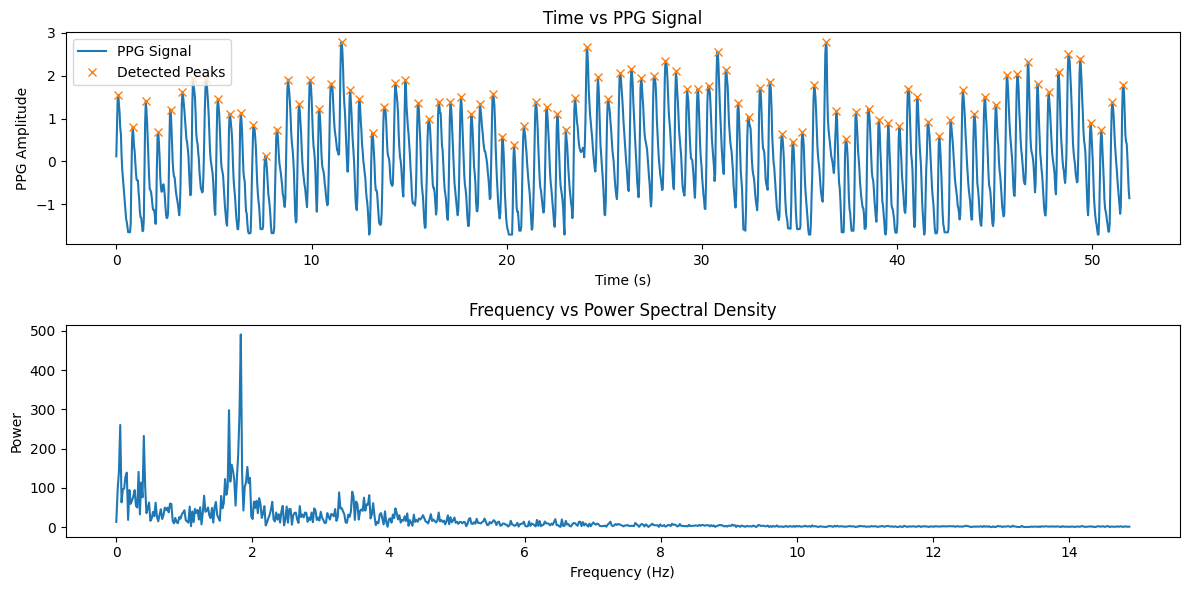

In [5]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [19]:
def calculate_hr(npz_data, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    PPG_Signal = npz_data['wave']
    hr_real = npz_data['hr']  # 실제 심박수 데이터
    bpm_per_frame = []
    times = []

    for start in range(0, len(PPG_Signal) - window_size, step_size):
        end = start + window_size
        segment = PPG_Signal[start:end]
        peaks, _ = find_peaks(segment, distance=10)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

    return times, bpm_per_frame, hr_real

def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)

    mse = mean_squared_error([mean_actual_hr], [mean_estimated_bpm])

    # 결과 출력
    print(f"Average Estimated Heart Rate: {mean_estimated_bpm:.2f}")
    print(f"Average Actual Heart RateR: {mean_actual_hr:.2f}")
    print(f"MSE between average estimated and actual HR: {mse:.2f}")
    print("---------------------------------------------------------------------------")

    return mse

def process_npz_files(directory):
    """디렉토리 내의 모든 NPZ 파일 처리"""
    mse_list = []
    subject_list  = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.npz'):
            file_path = os.path.join(directory, file_name)
            print(f"Processing {file_path}...")
            npz_data = np.load(file_path)
            times, bpm_per_frame, hr_real = calculate_hr(npz_data)
            mse = plot_hr(times, bpm_per_frame, hr_real)
            mse_list.append(mse)

            # 파일 이름에서 'subject'와 숫자 추출
            subject = file_name.replace('.npz', '')
            subject_list.append(subject)

    return mse_list, subject_list

Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz...


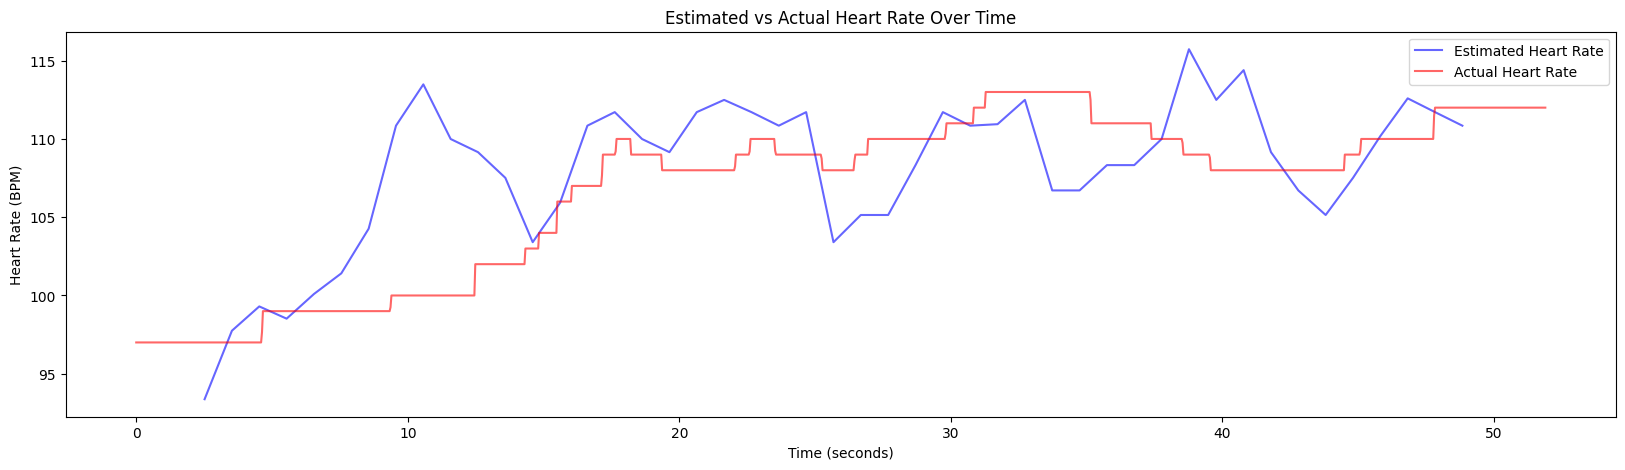

Average Estimated Heart Rate: 108.08
Average Actual Heart RateR: 106.70
MSE between average estimated and actual HR: 1.89
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject10.npz...


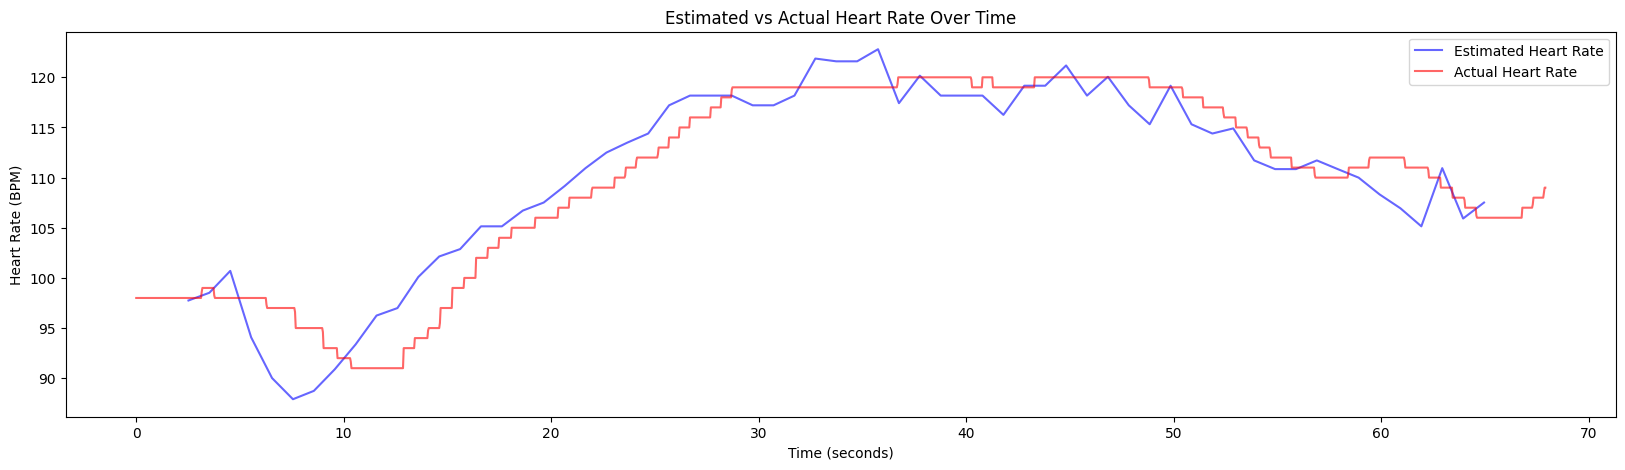

Average Estimated Heart Rate: 110.33
Average Actual Heart RateR: 109.81
MSE between average estimated and actual HR: 0.27
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject11.npz...


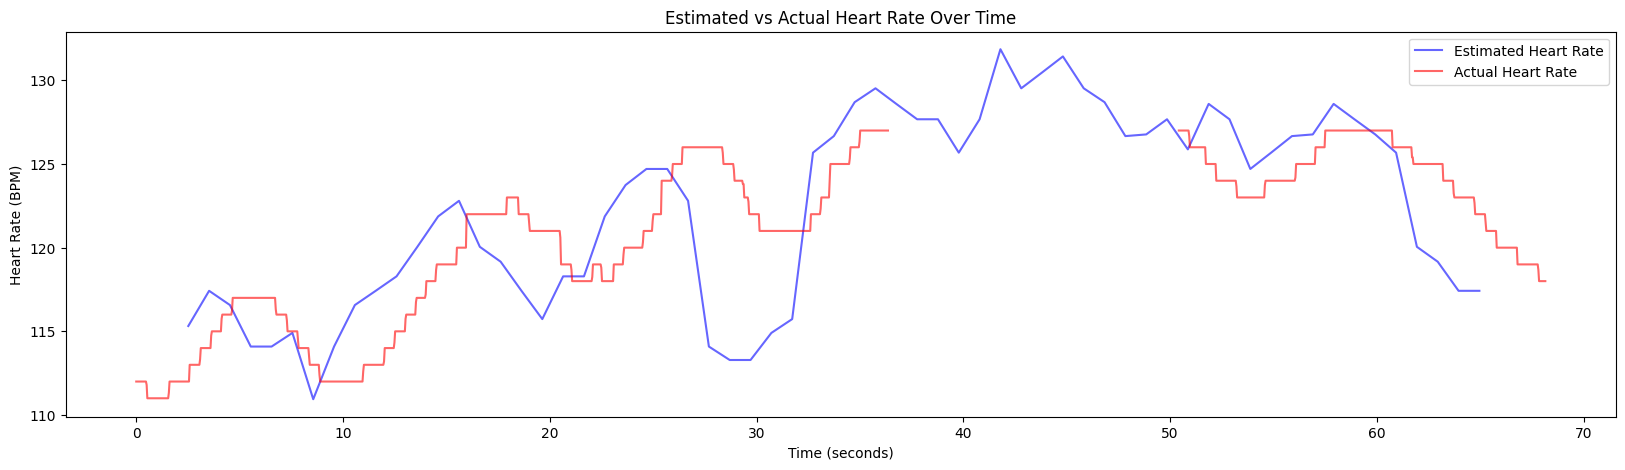

Average Estimated Heart Rate: 122.41
Average Actual Heart RateR: 120.68
MSE between average estimated and actual HR: 2.97
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject12.npz...


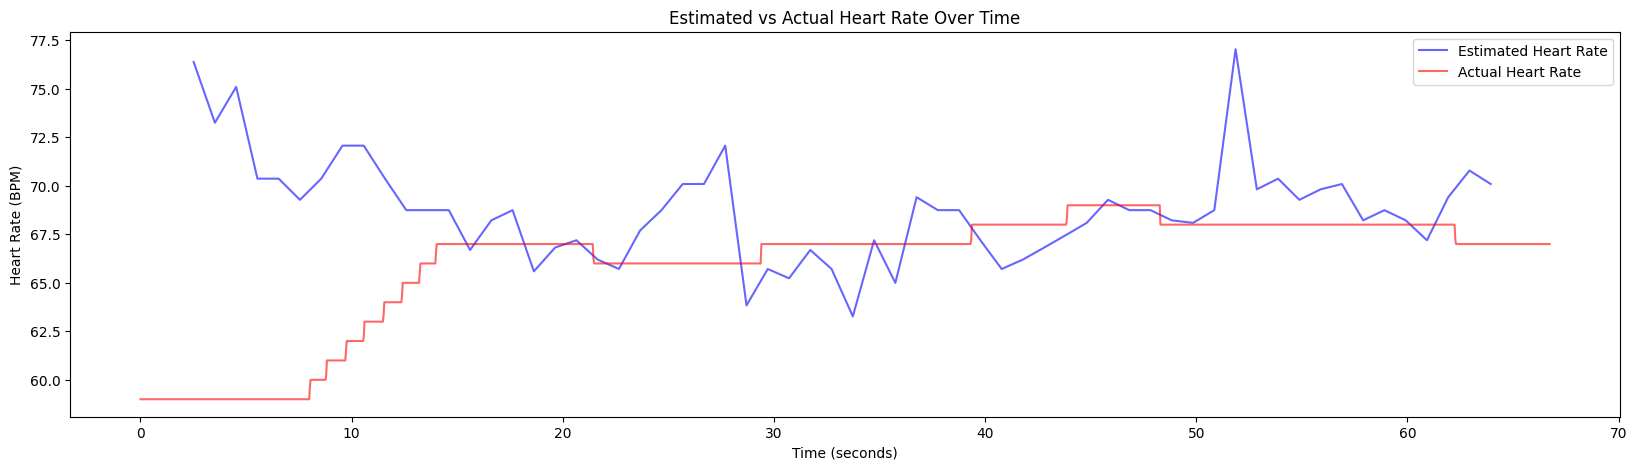

Average Estimated Heart Rate: 68.74
Average Actual Heart RateR: 65.97
MSE between average estimated and actual HR: 7.69
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject13.npz...


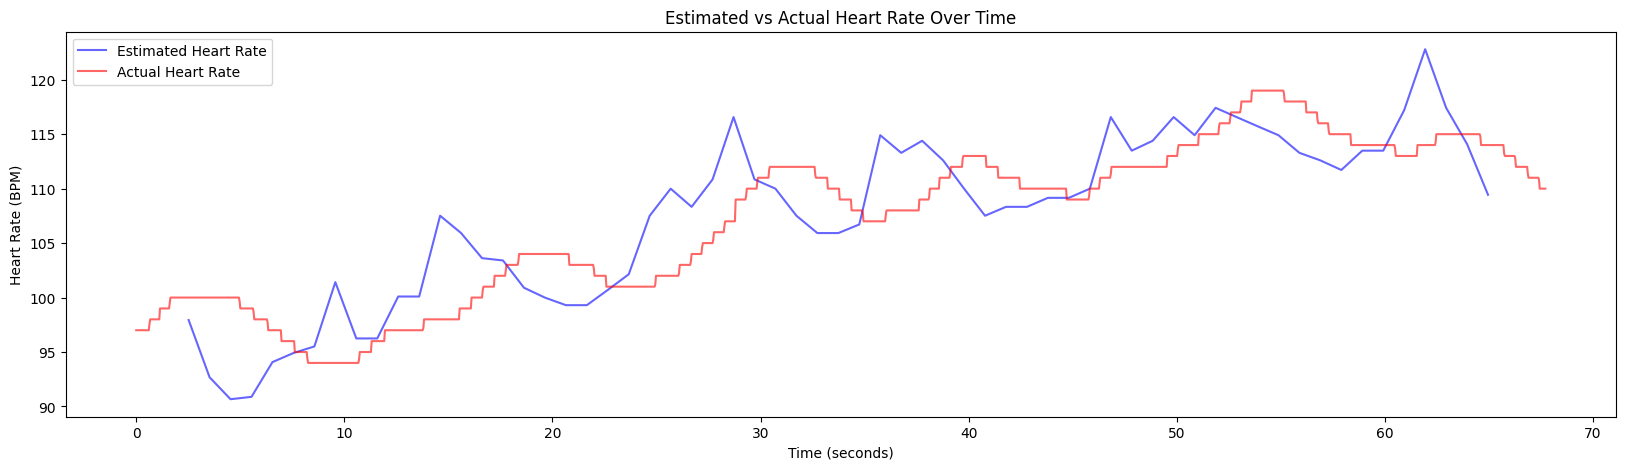

Average Estimated Heart Rate: 107.58
Average Actual Heart RateR: 107.10
MSE between average estimated and actual HR: 0.23
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject14.npz...


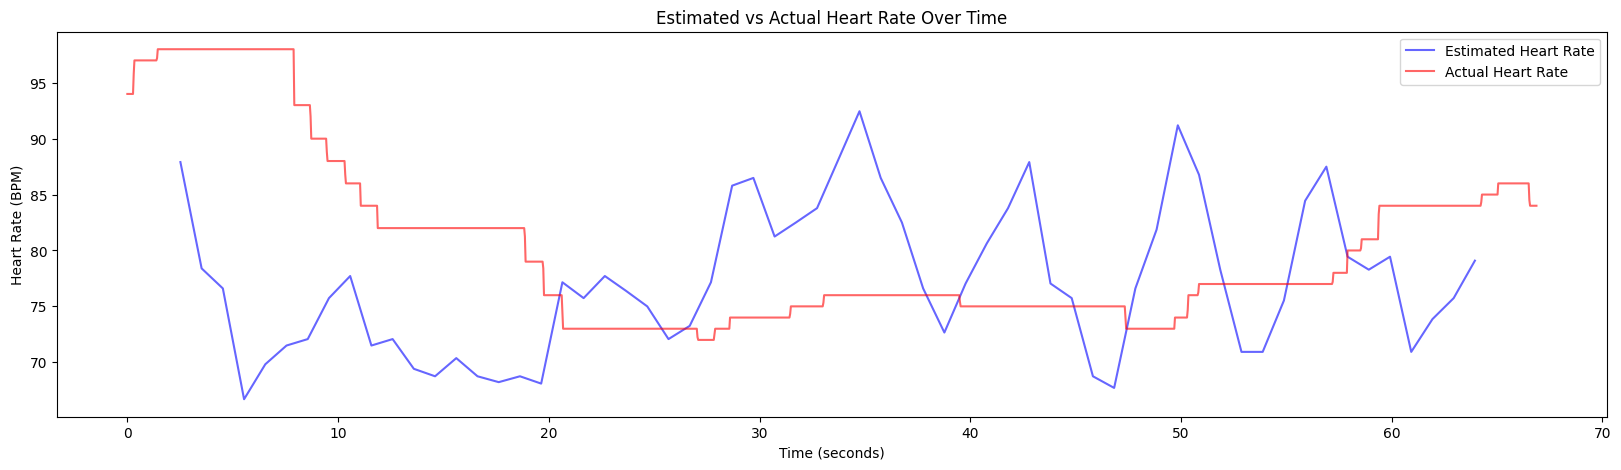

Average Estimated Heart Rate: 77.18
Average Actual Heart RateR: 80.41
MSE between average estimated and actual HR: 10.48
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject15.npz...


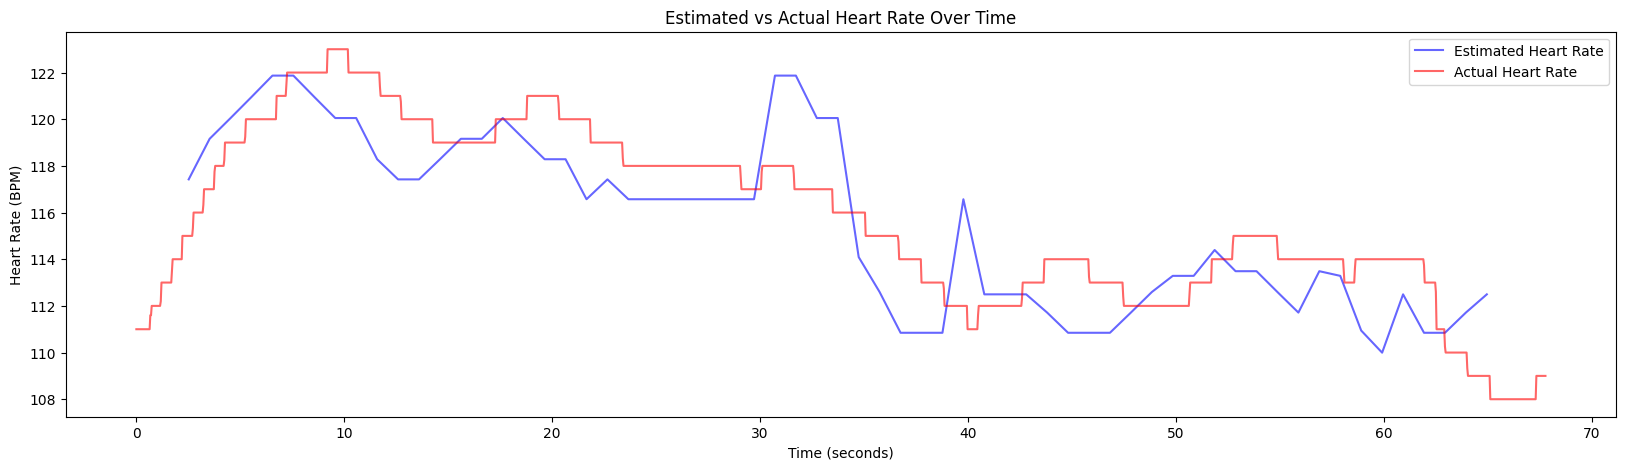

Average Estimated Heart Rate: 115.59
Average Actual Heart RateR: 115.79
MSE between average estimated and actual HR: 0.04
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject16.npz...


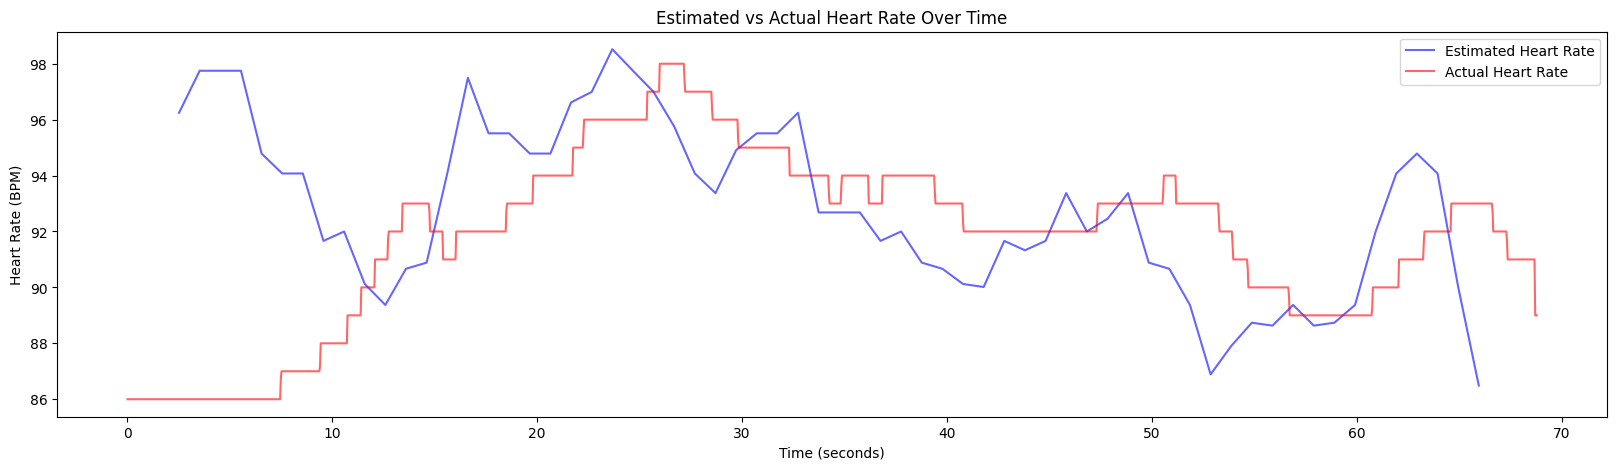

Average Estimated Heart Rate: 92.83
Average Actual Heart RateR: 91.80
MSE between average estimated and actual HR: 1.07
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject17.npz...


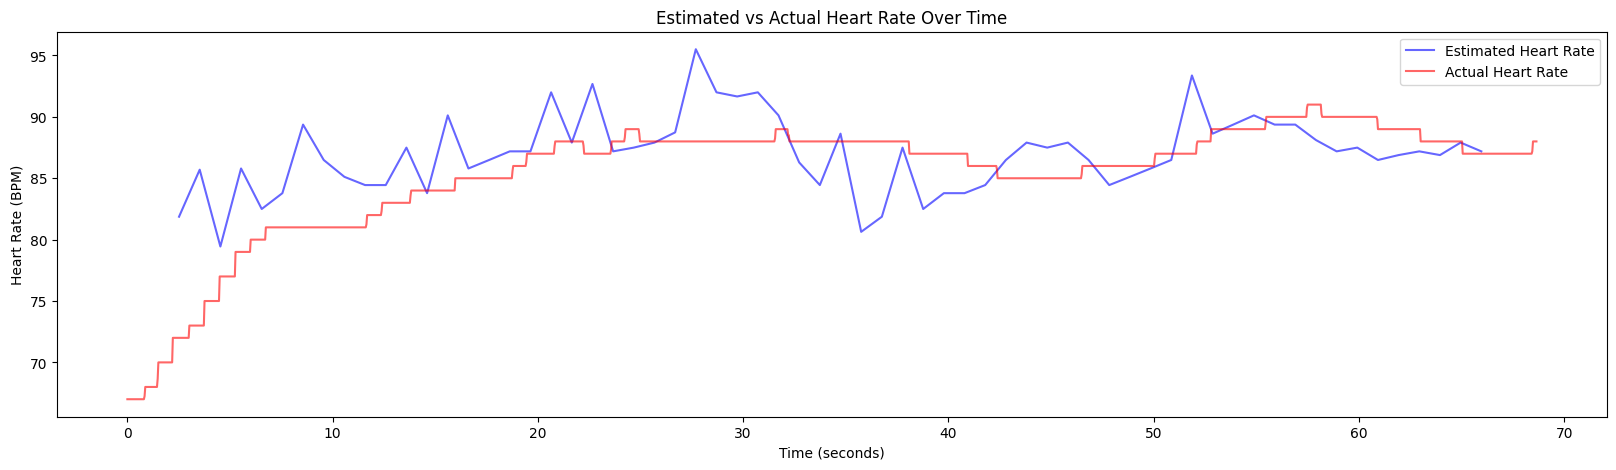

Average Estimated Heart Rate: 87.03
Average Actual Heart RateR: 85.40
MSE between average estimated and actual HR: 2.64
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject18.npz...


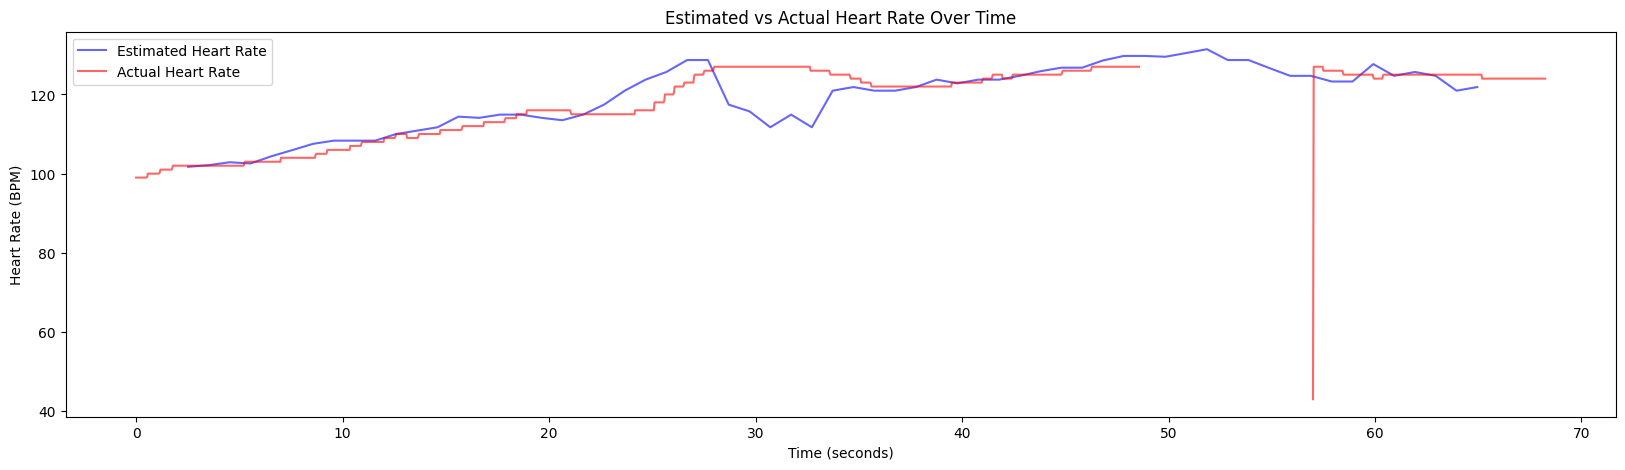

Average Estimated Heart Rate: 119.24
Average Actual Heart RateR: 117.91
MSE between average estimated and actual HR: 1.77
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject20.npz...


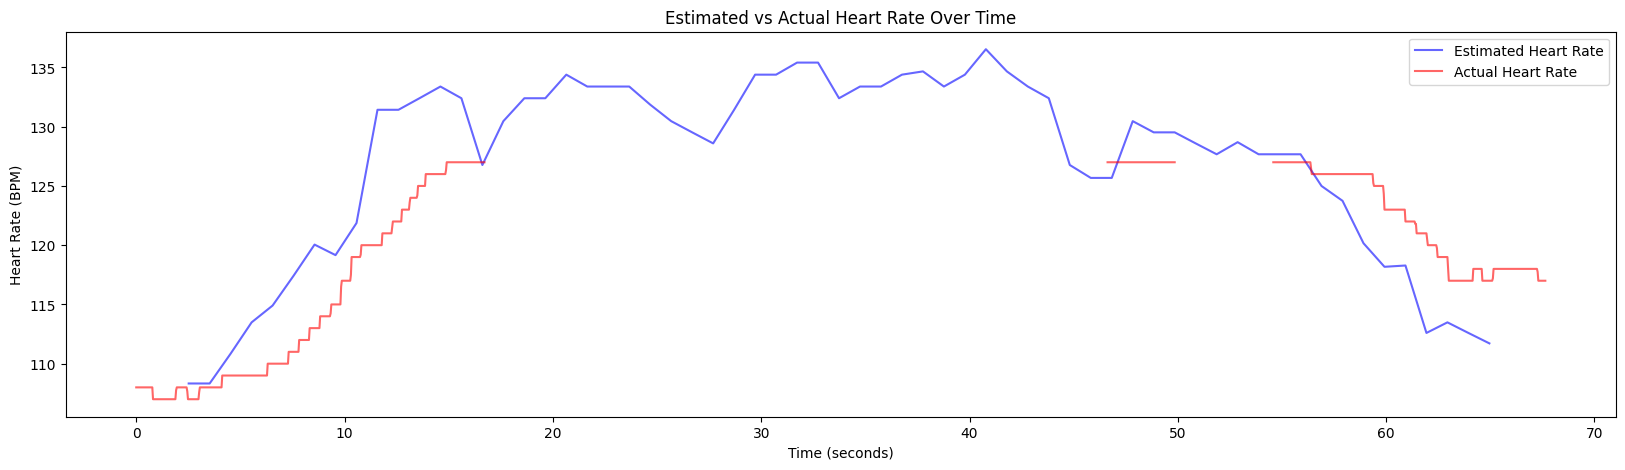

Average Estimated Heart Rate: 127.11
Average Actual Heart RateR: 119.05
MSE between average estimated and actual HR: 64.88
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject22.npz...


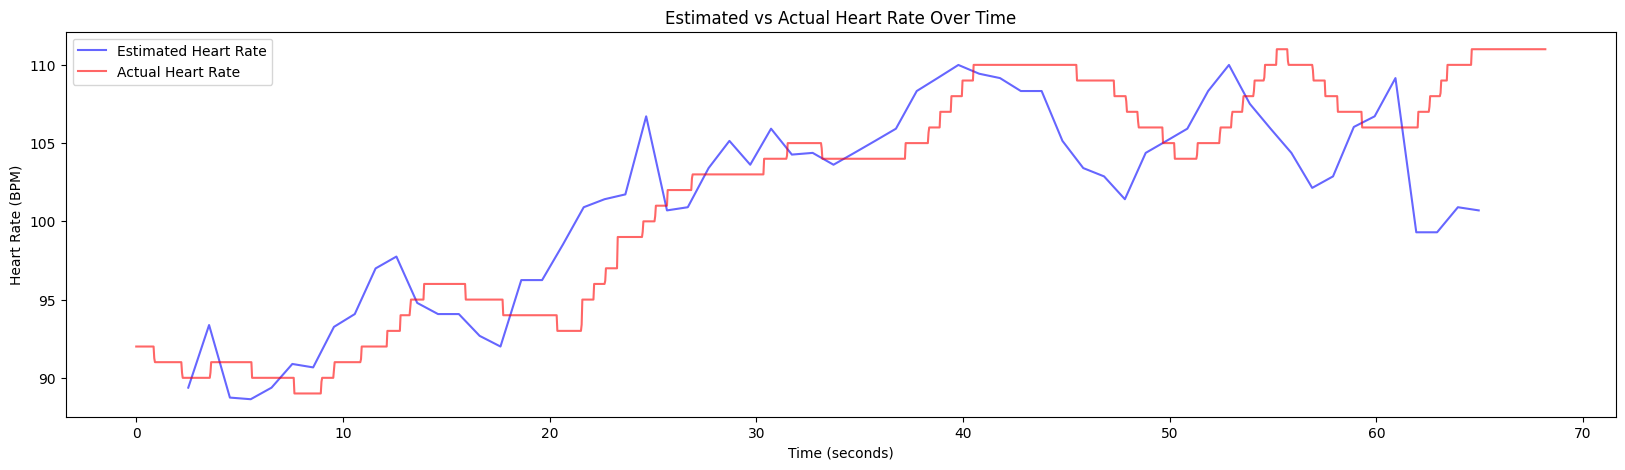

Average Estimated Heart Rate: 101.34
Average Actual Heart RateR: 101.79
MSE between average estimated and actual HR: 0.21
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject23.npz...


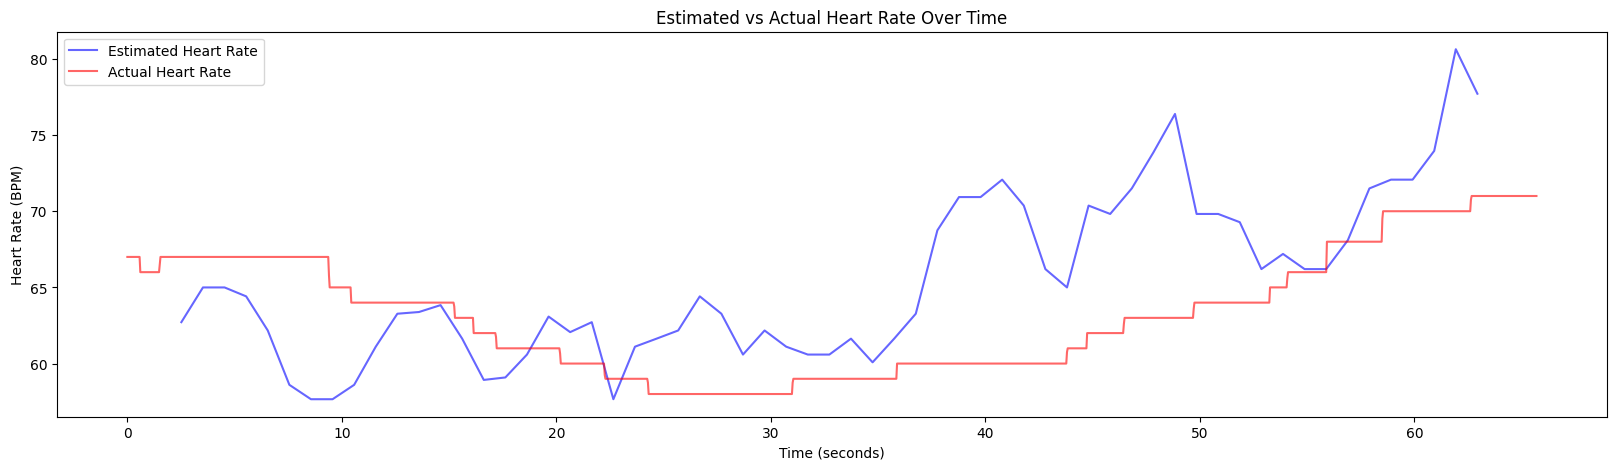

Average Estimated Heart Rate: 65.42
Average Actual Heart RateR: 63.29
MSE between average estimated and actual HR: 4.53
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject24.npz...


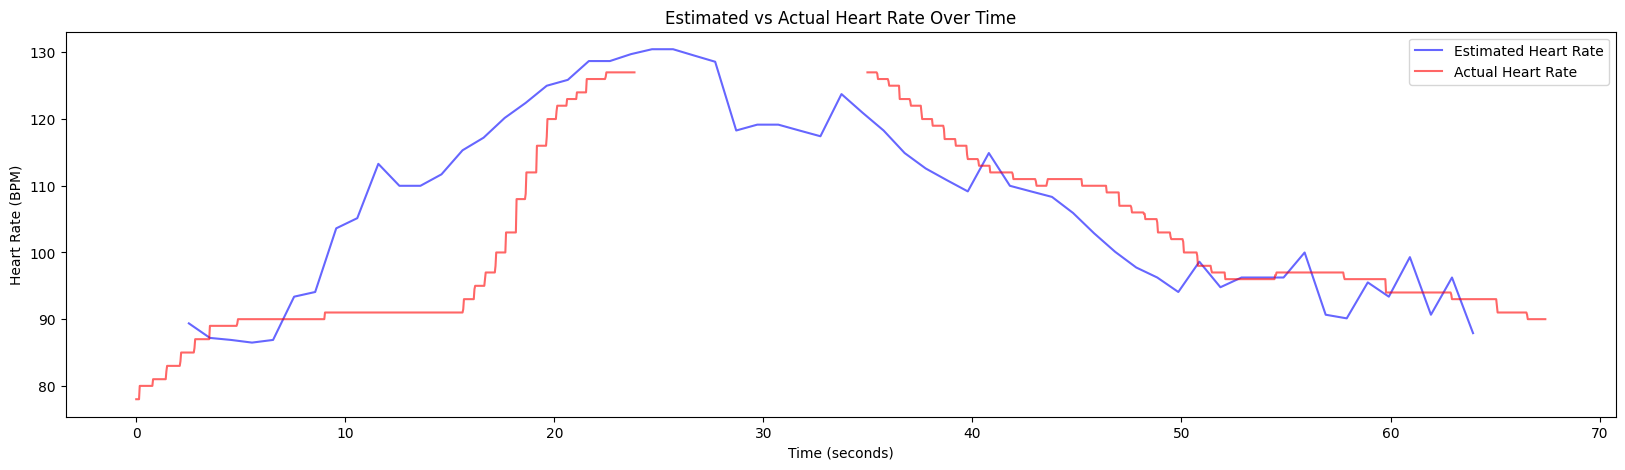

Average Estimated Heart Rate: 107.71
Average Actual Heart RateR: 100.90
MSE between average estimated and actual HR: 46.43
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject25.npz...


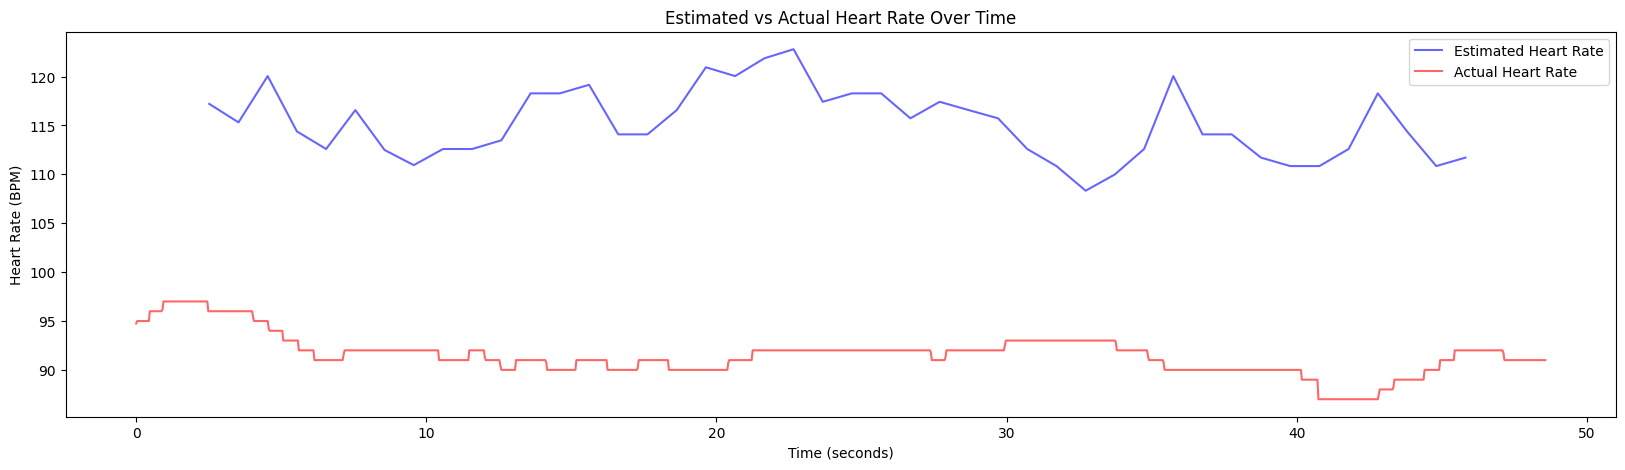

Average Estimated Heart Rate: 115.17
Average Actual Heart RateR: 91.53
MSE between average estimated and actual HR: 558.93
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject26.npz...


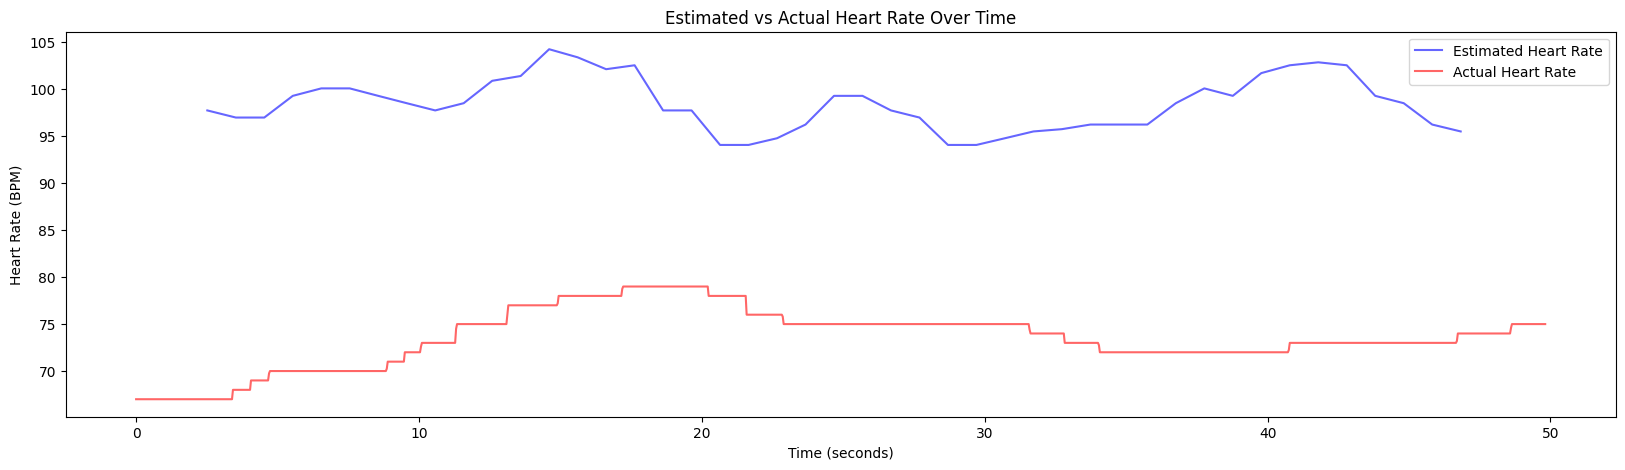

Average Estimated Heart Rate: 98.40
Average Actual Heart RateR: 73.53
MSE between average estimated and actual HR: 618.46
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject27.npz...


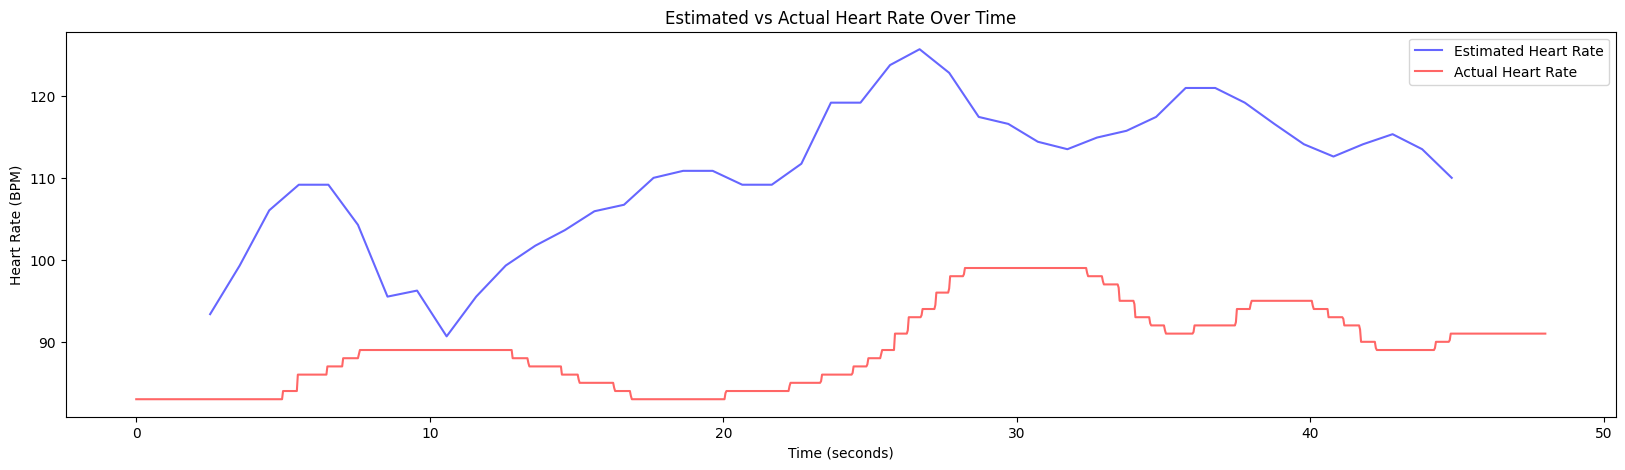

Average Estimated Heart Rate: 110.60
Average Actual Heart RateR: 89.37
MSE between average estimated and actual HR: 450.95
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject3.npz...


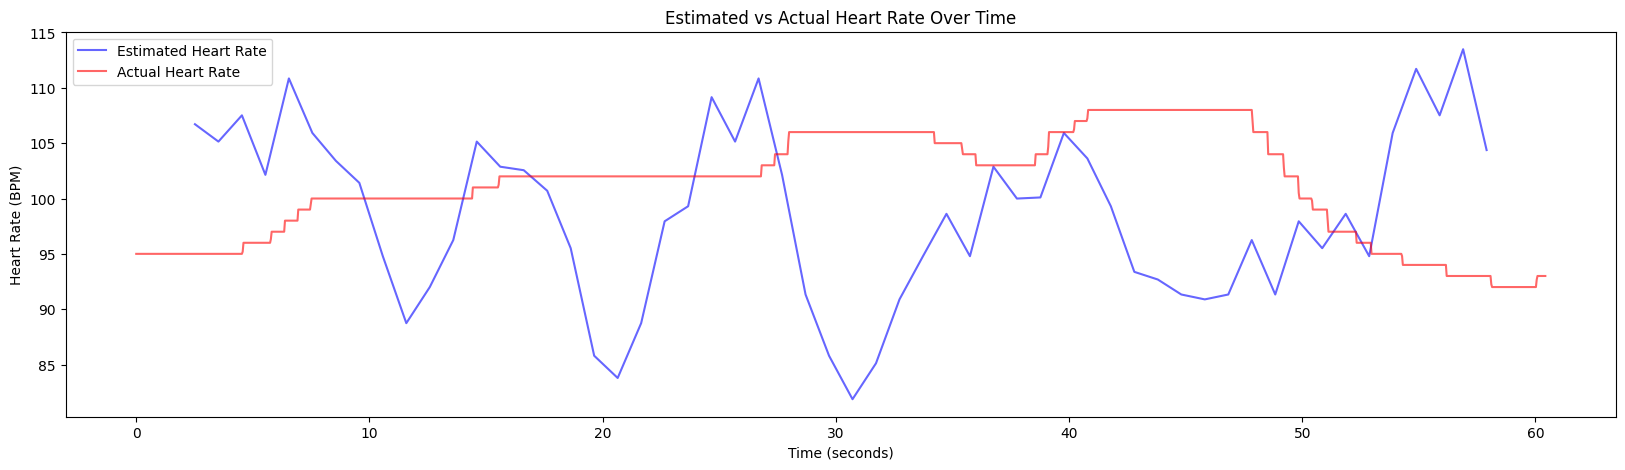

Average Estimated Heart Rate: 98.51
Average Actual Heart RateR: 101.17
MSE between average estimated and actual HR: 7.08
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject30.npz...


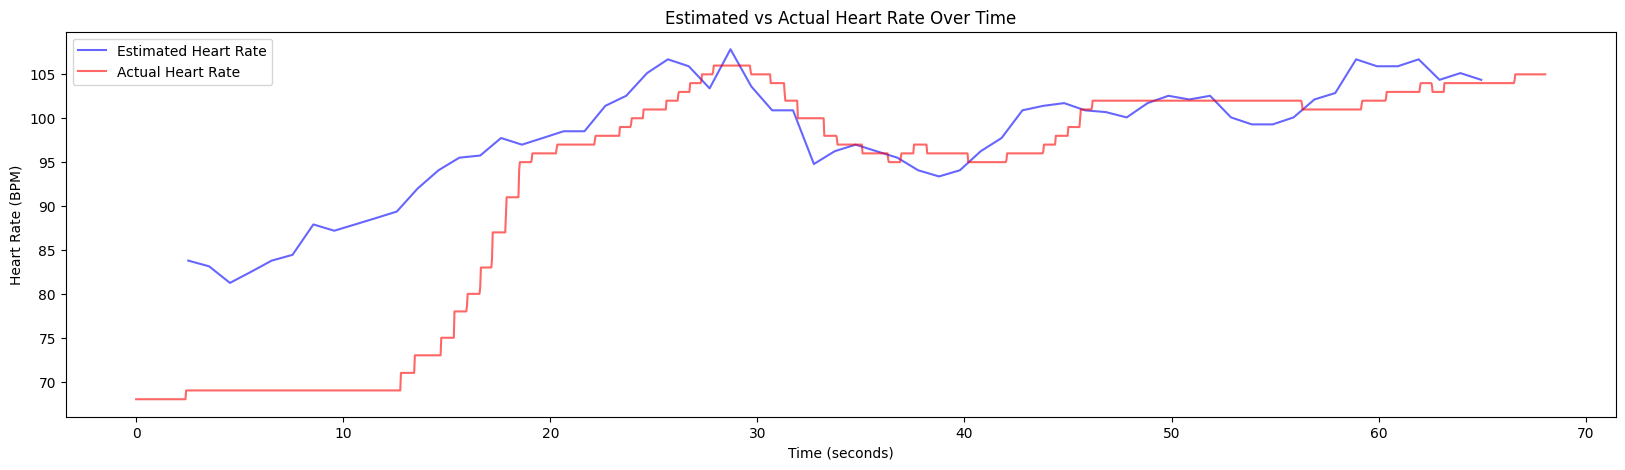

Average Estimated Heart Rate: 97.75
Average Actual Heart RateR: 92.71
MSE between average estimated and actual HR: 25.38
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject31.npz...


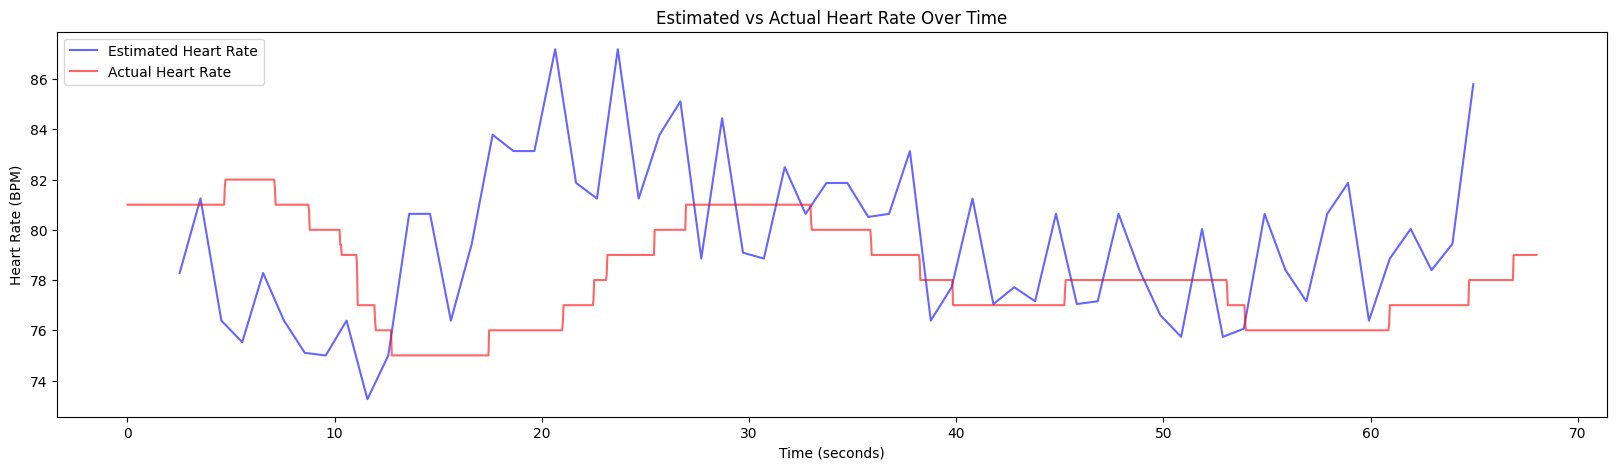

Average Estimated Heart Rate: 79.54
Average Actual Heart RateR: 78.24
MSE between average estimated and actual HR: 1.69
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject32.npz...


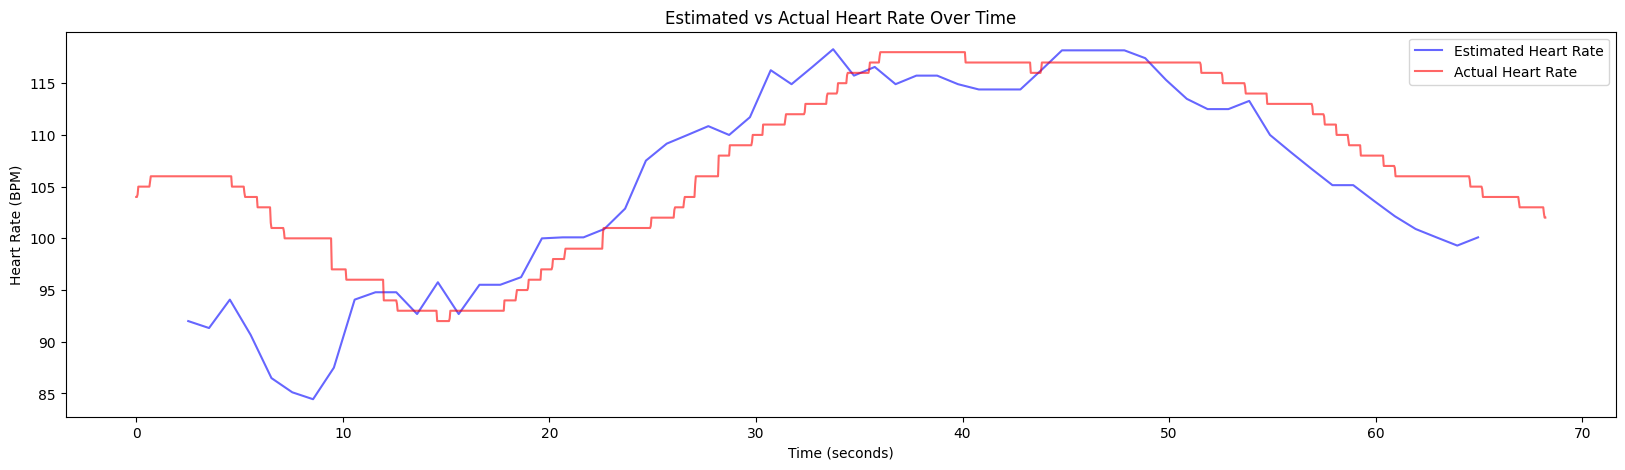

Average Estimated Heart Rate: 105.47
Average Actual Heart RateR: 107.33
MSE between average estimated and actual HR: 3.46
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject33.npz...


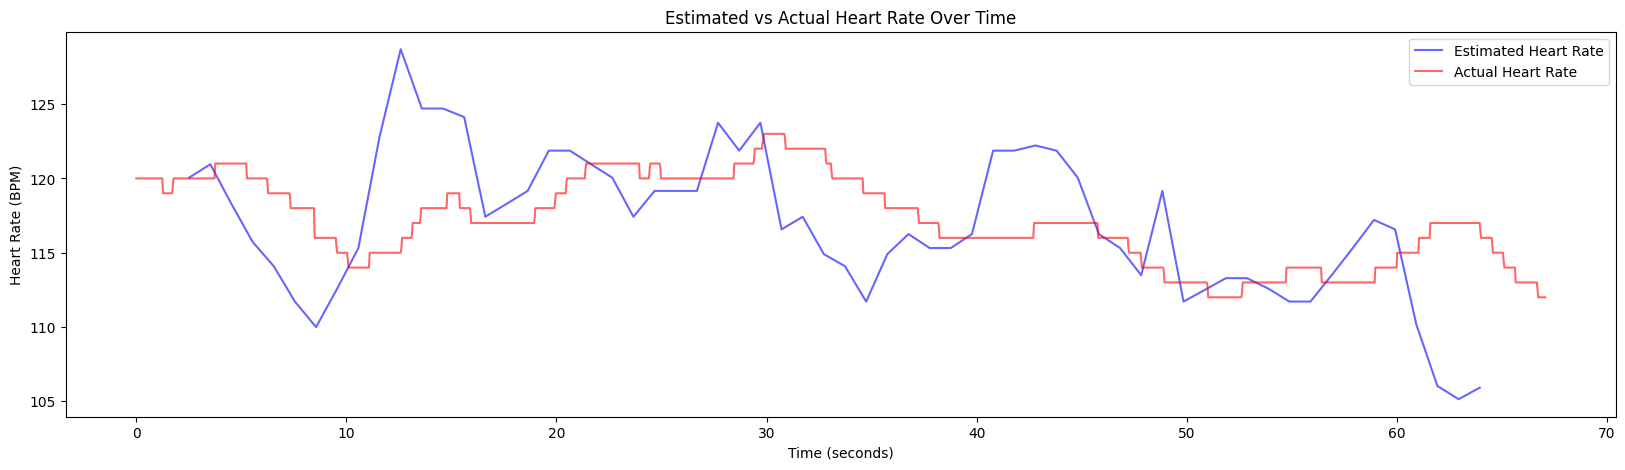

Average Estimated Heart Rate: 116.92
Average Actual Heart RateR: 117.18
MSE between average estimated and actual HR: 0.06
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject34.npz...


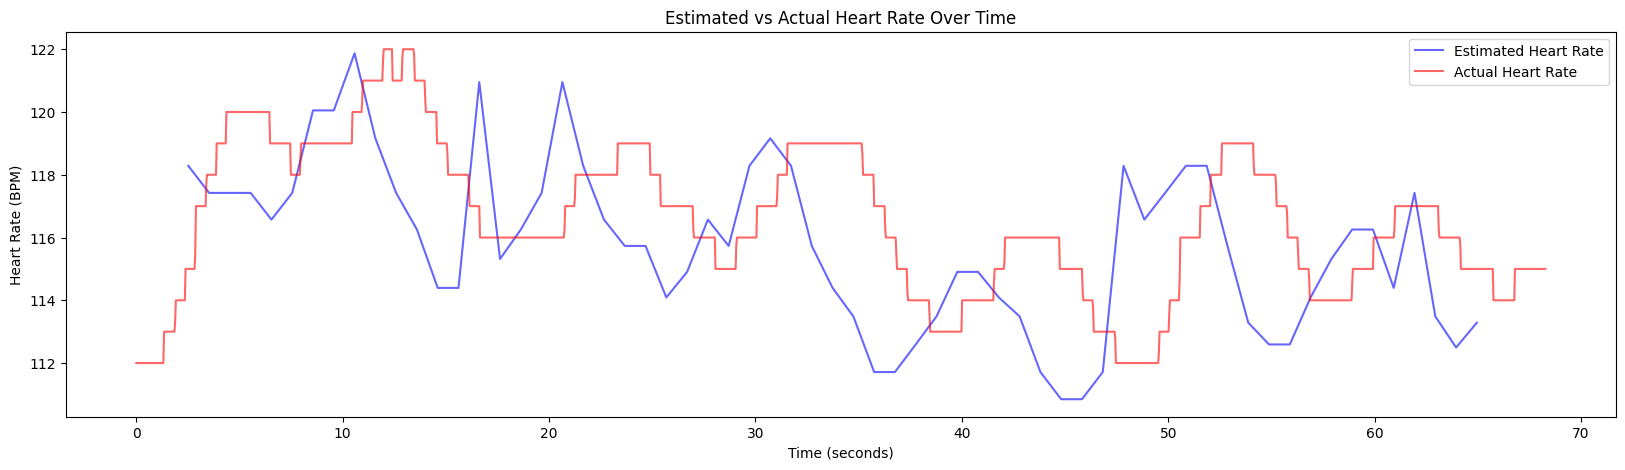

Average Estimated Heart Rate: 115.78
Average Actual Heart RateR: 116.55
MSE between average estimated and actual HR: 0.59
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject35.npz...


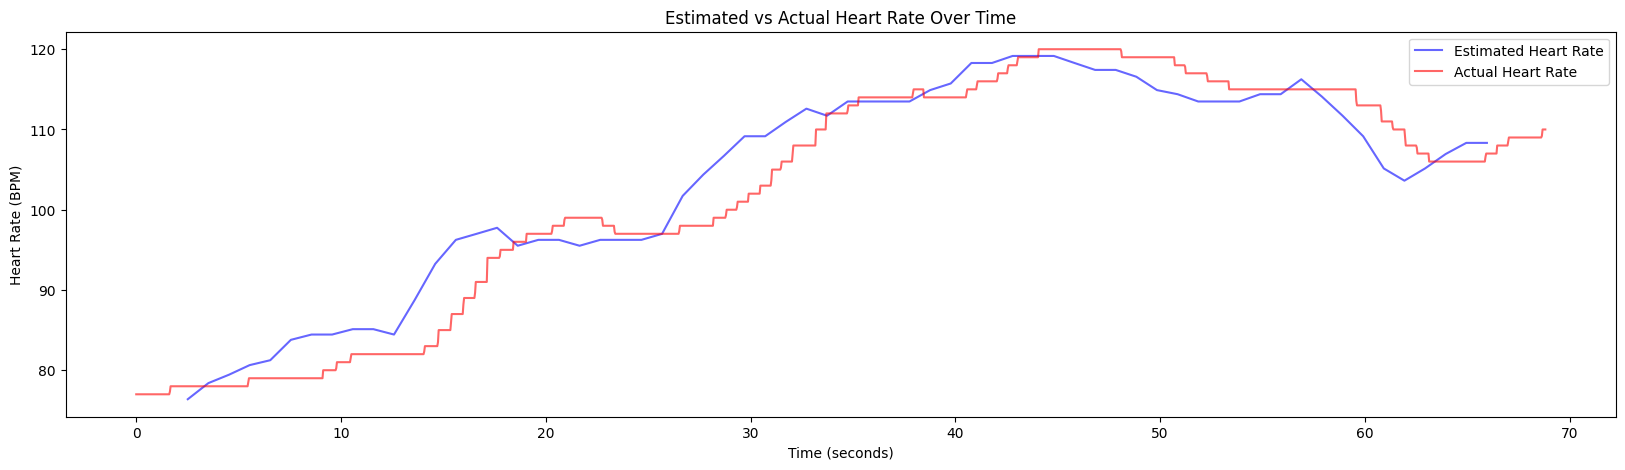

Average Estimated Heart Rate: 103.87
Average Actual Heart RateR: 102.36
MSE between average estimated and actual HR: 2.28
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject36.npz...


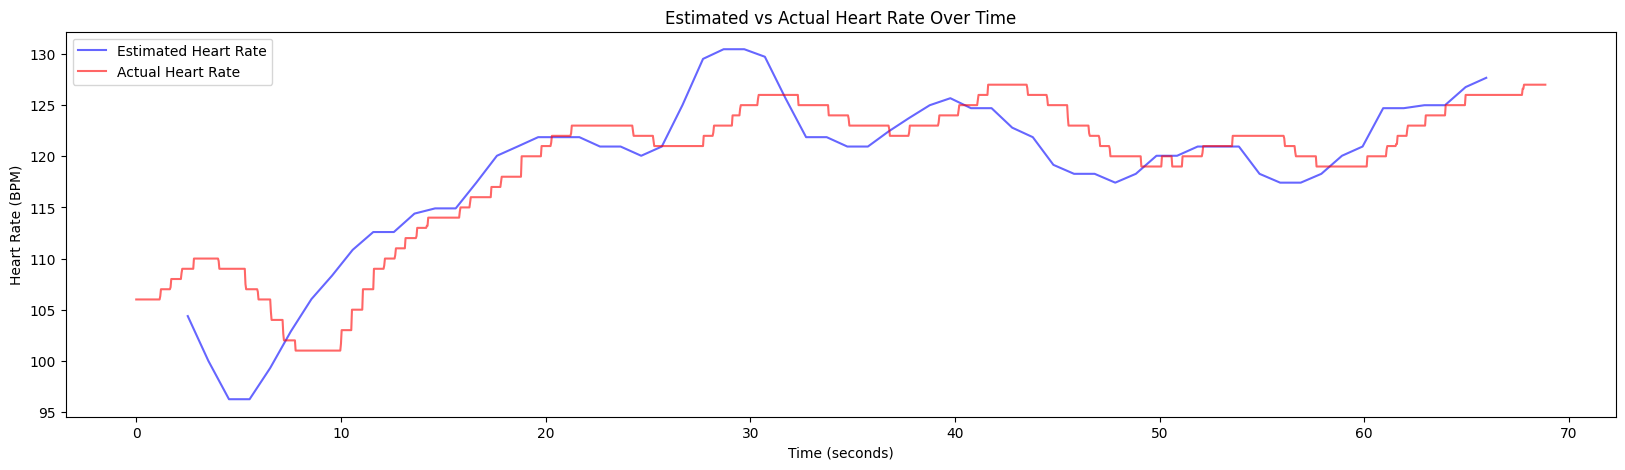

Average Estimated Heart Rate: 118.89
Average Actual Heart RateR: 119.02
MSE between average estimated and actual HR: 0.02
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject37.npz...


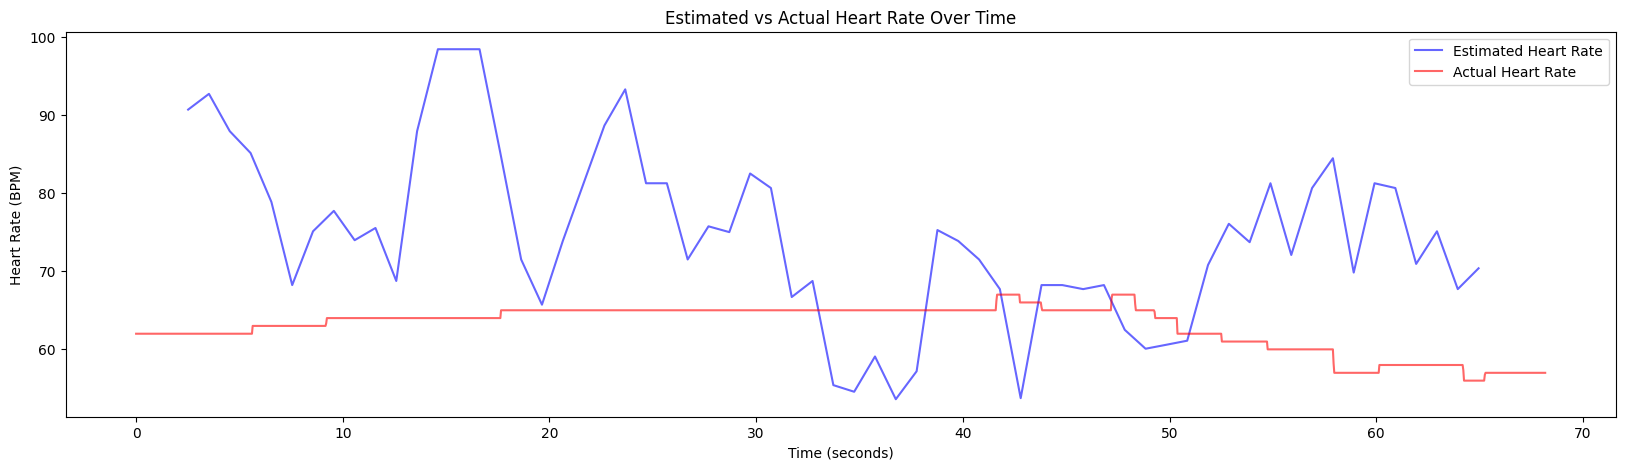

Average Estimated Heart Rate: 74.50
Average Actual Heart RateR: 62.97
MSE between average estimated and actual HR: 132.93
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject38.npz...


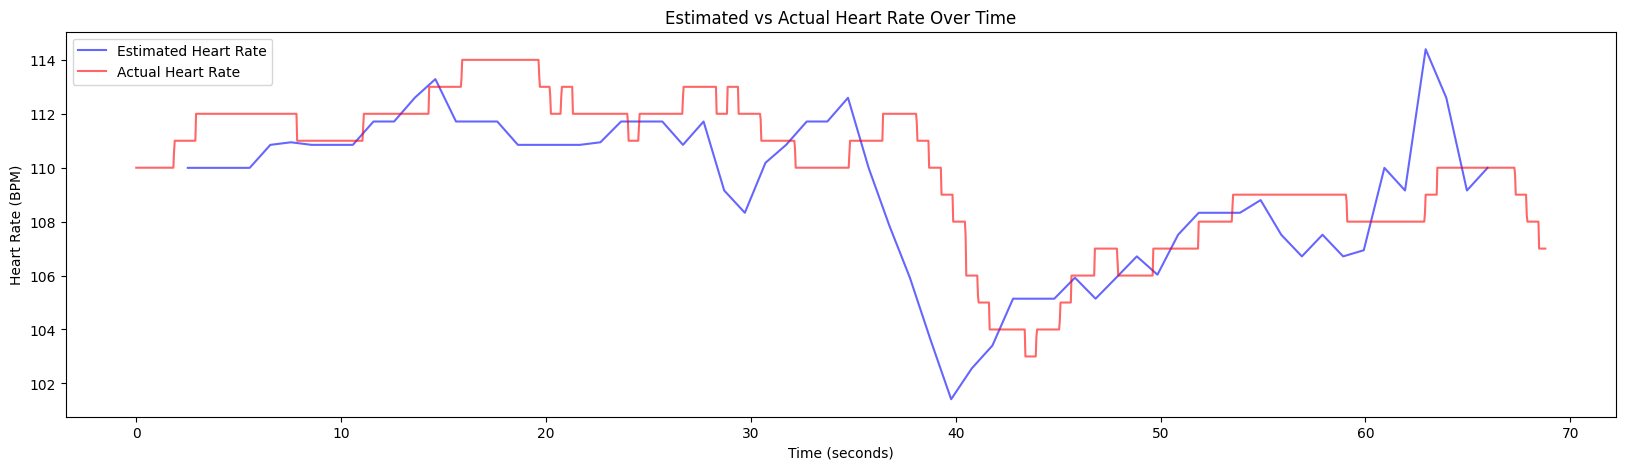

Average Estimated Heart Rate: 109.18
Average Actual Heart RateR: 110.00
MSE between average estimated and actual HR: 0.67
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject39.npz...


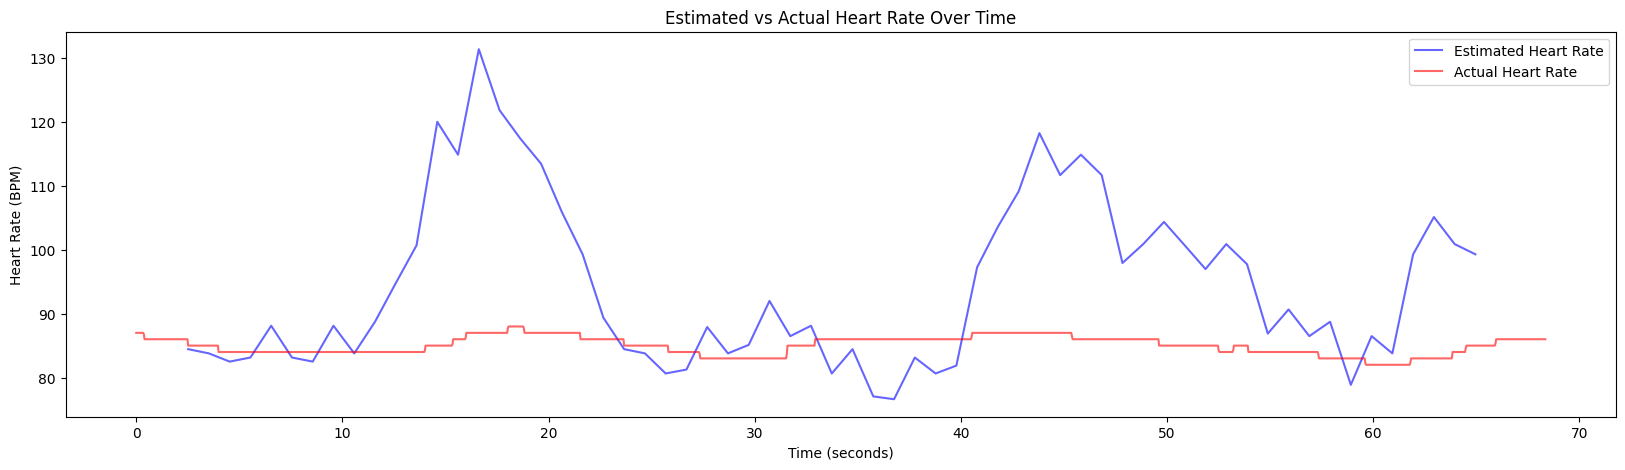

Average Estimated Heart Rate: 94.42
Average Actual Heart RateR: 85.02
MSE between average estimated and actual HR: 88.22
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject4.npz...


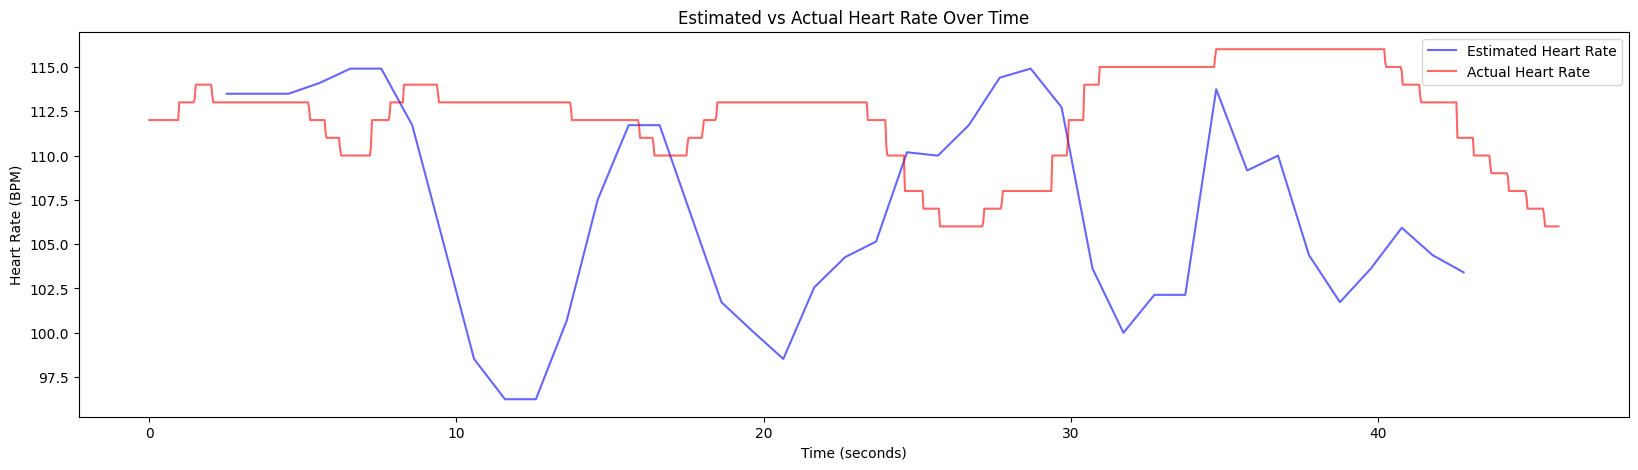

Average Estimated Heart Rate: 106.85
Average Actual Heart RateR: 112.27
MSE between average estimated and actual HR: 29.38
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject40.npz...


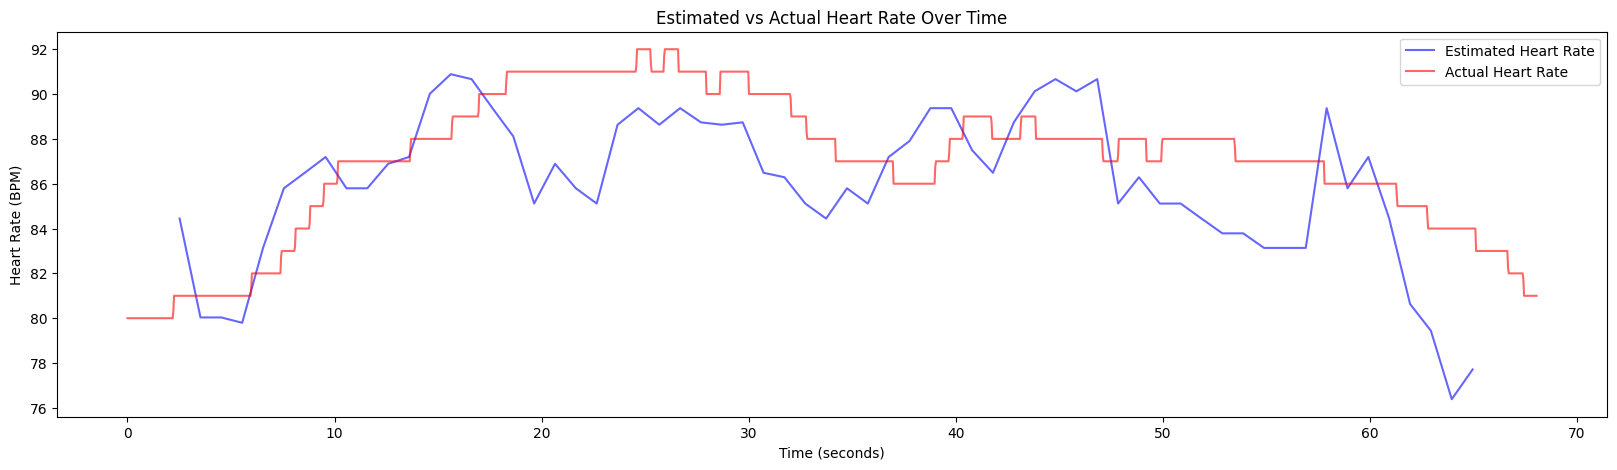

Average Estimated Heart Rate: 86.06
Average Actual Heart RateR: 86.97
MSE between average estimated and actual HR: 0.82
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject41.npz...


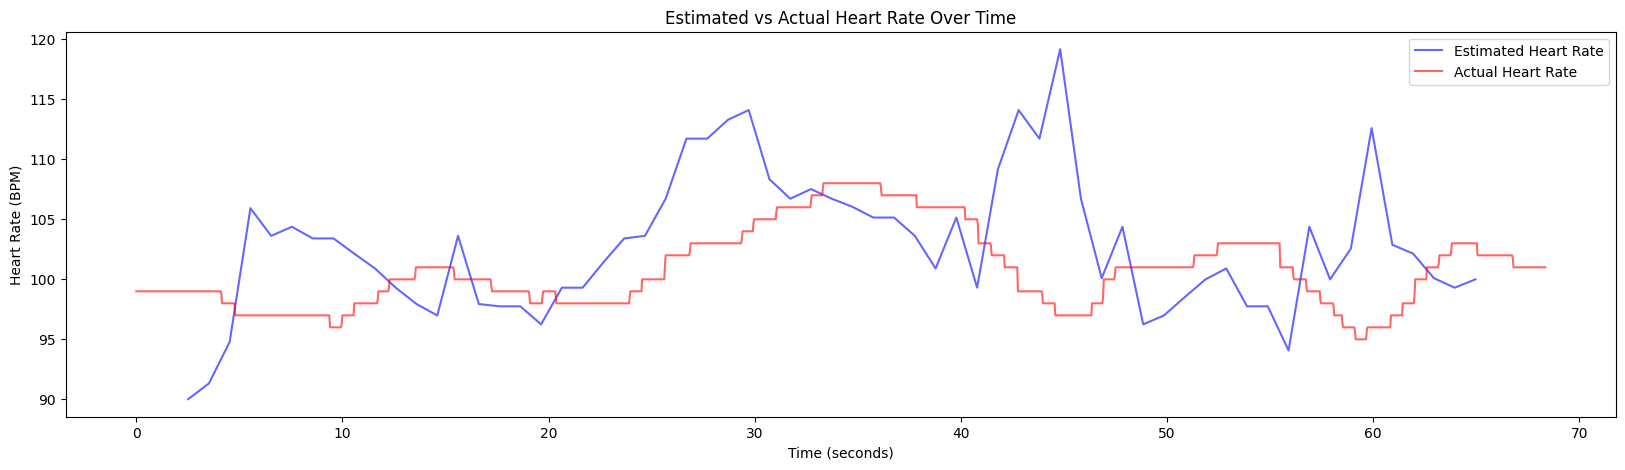

Average Estimated Heart Rate: 102.83
Average Actual Heart RateR: 100.78
MSE between average estimated and actual HR: 4.19
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject42.npz...


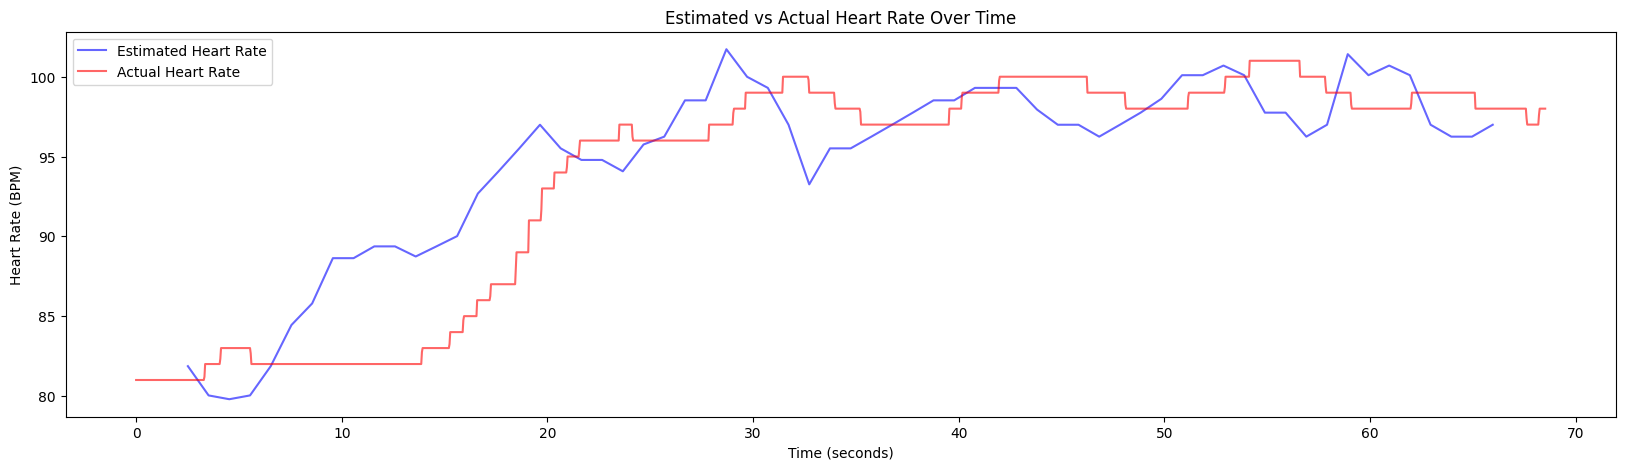

Average Estimated Heart Rate: 94.90
Average Actual Heart RateR: 93.87
MSE between average estimated and actual HR: 1.07
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject43.npz...


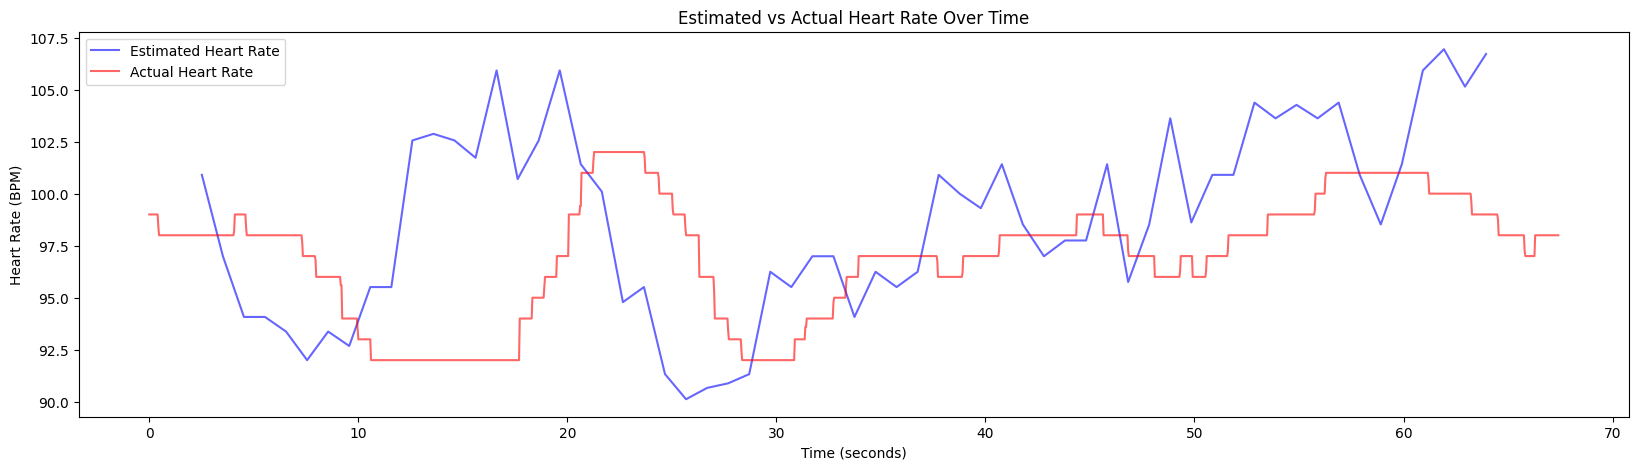

Average Estimated Heart Rate: 98.80
Average Actual Heart RateR: 97.04
MSE between average estimated and actual HR: 3.08
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject44.npz...


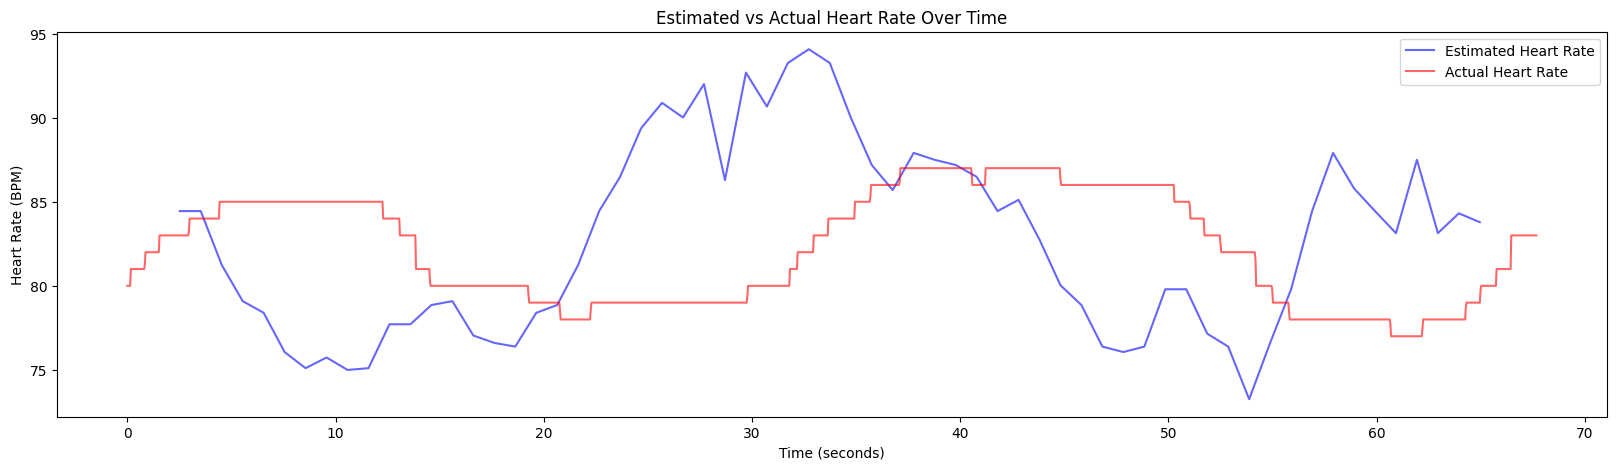

Average Estimated Heart Rate: 82.69
Average Actual Heart RateR: 82.21
MSE between average estimated and actual HR: 0.22
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject45.npz...


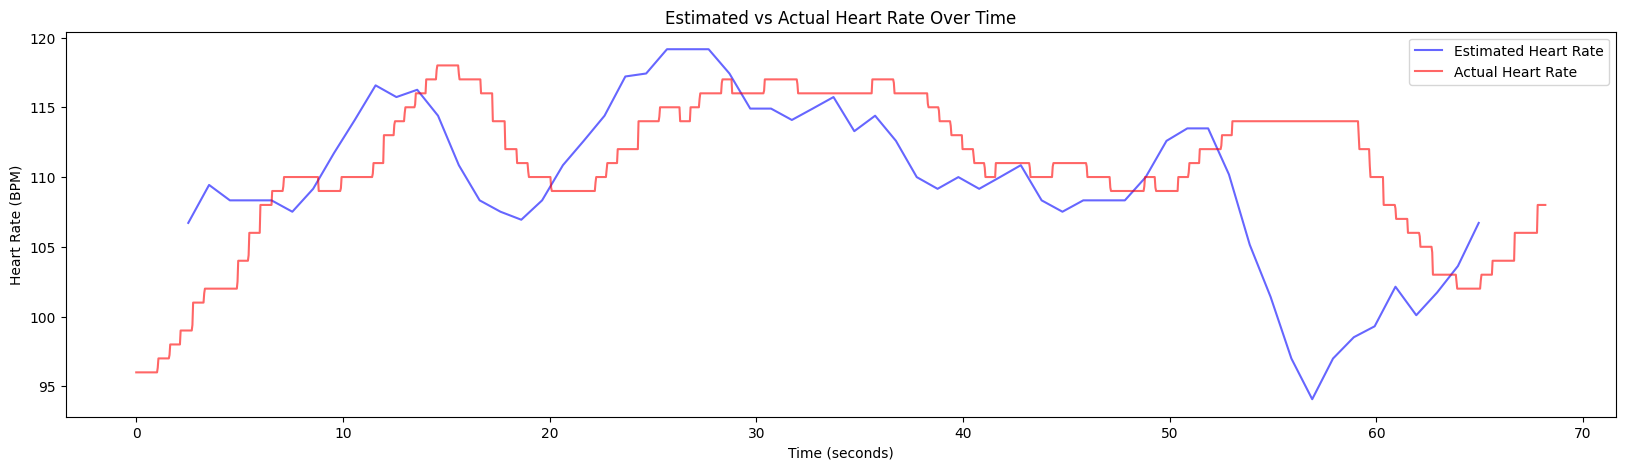

Average Estimated Heart Rate: 109.80
Average Actual Heart RateR: 110.82
MSE between average estimated and actual HR: 1.05
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject46.npz...


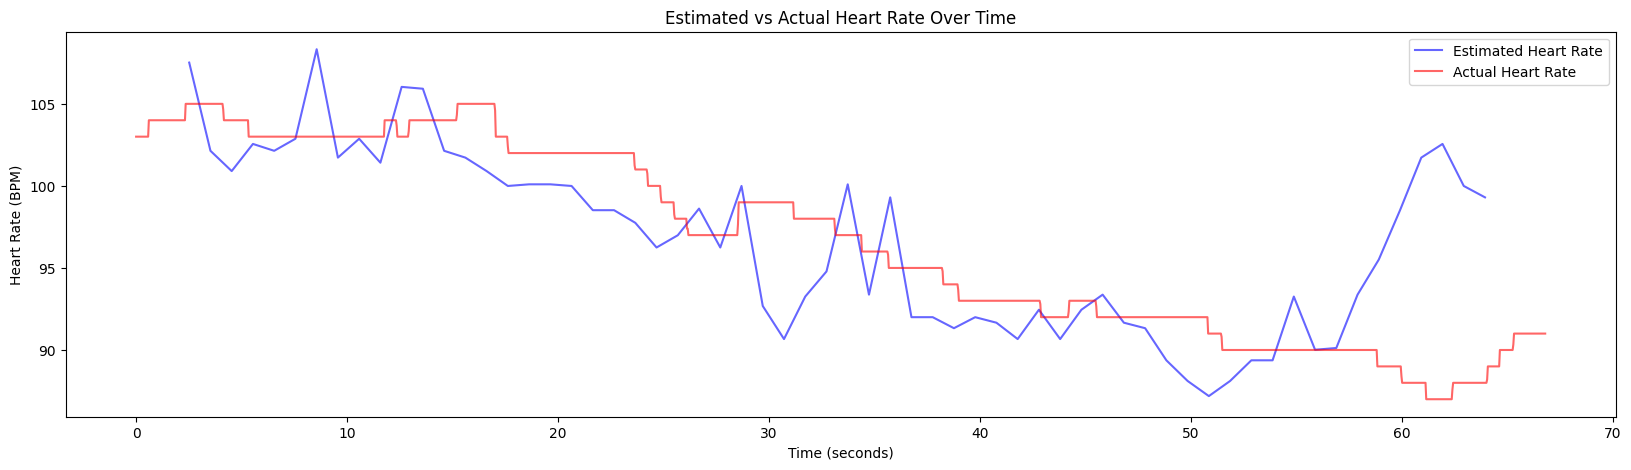

Average Estimated Heart Rate: 96.68
Average Actual Heart RateR: 96.68
MSE between average estimated and actual HR: 0.00
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject47.npz...


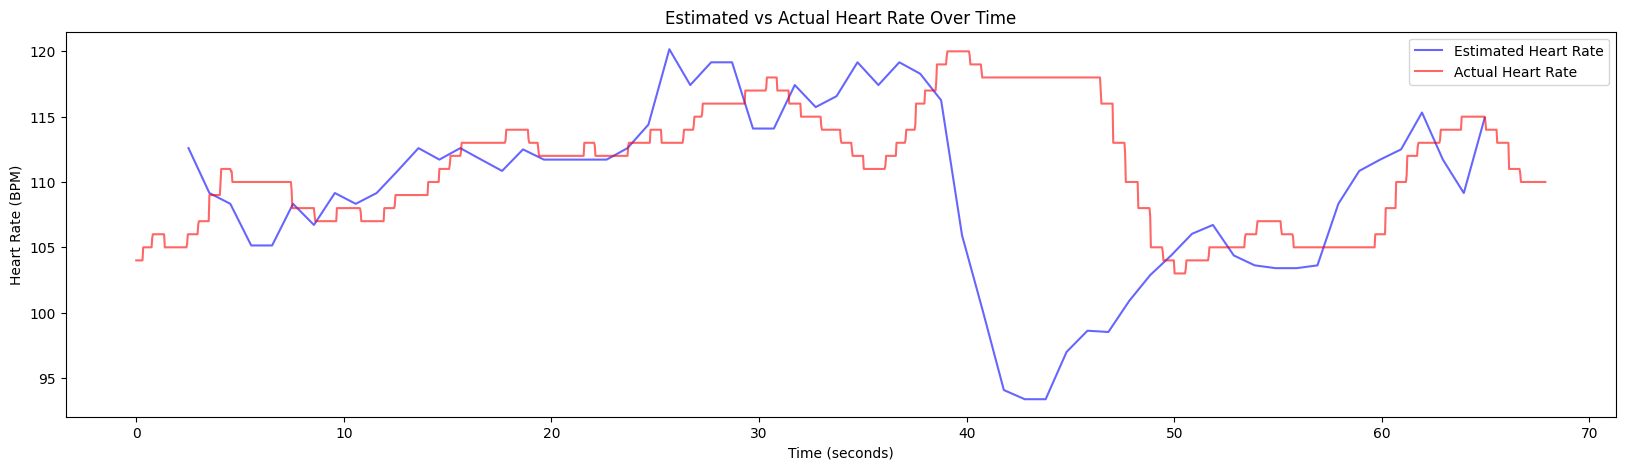

Average Estimated Heart Rate: 109.48
Average Actual Heart RateR: 111.38
MSE between average estimated and actual HR: 3.58
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject48.npz...


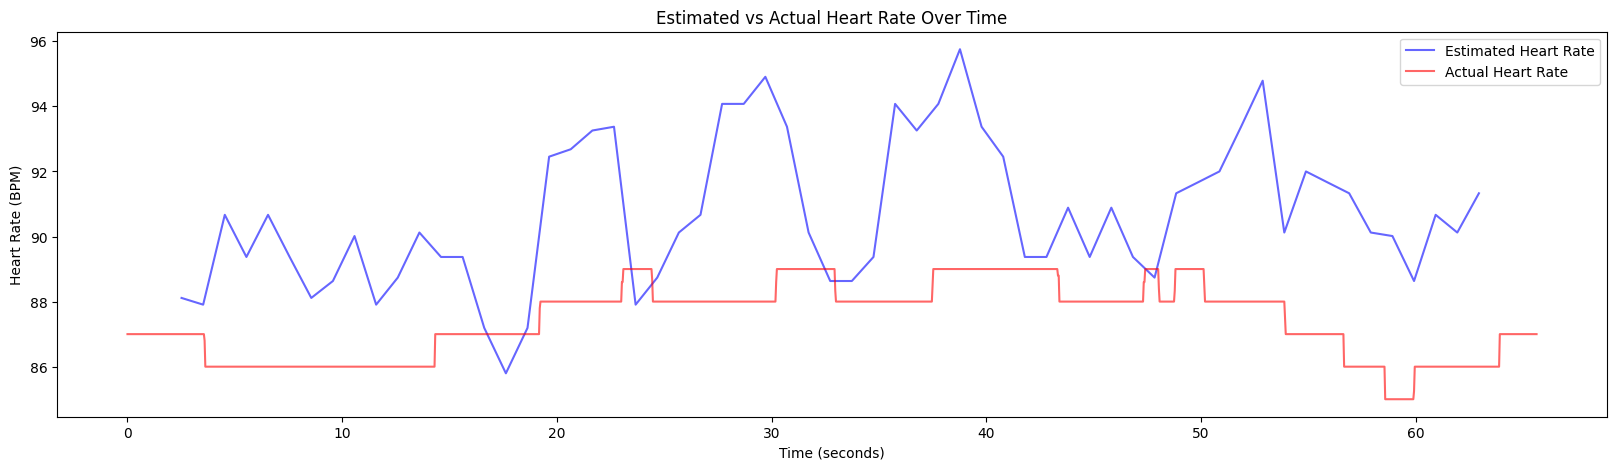

Average Estimated Heart Rate: 90.67
Average Actual Heart RateR: 87.42
MSE between average estimated and actual HR: 10.59
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject49.npz...


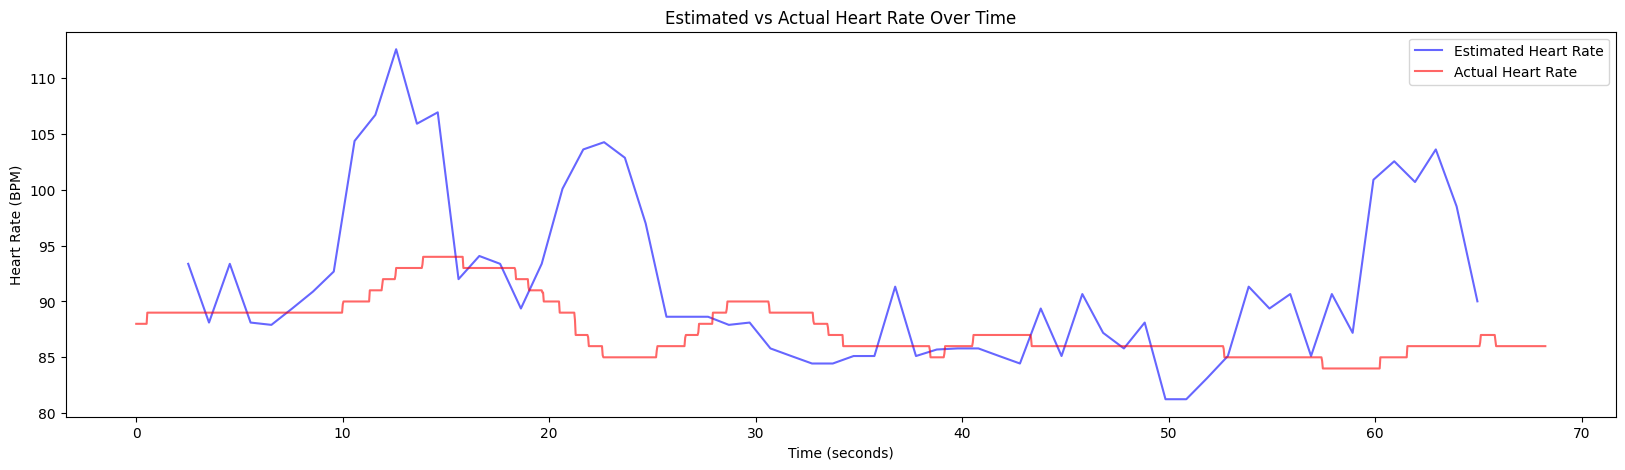

Average Estimated Heart Rate: 91.64
Average Actual Heart RateR: 87.57
MSE between average estimated and actual HR: 16.57
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject5.npz...


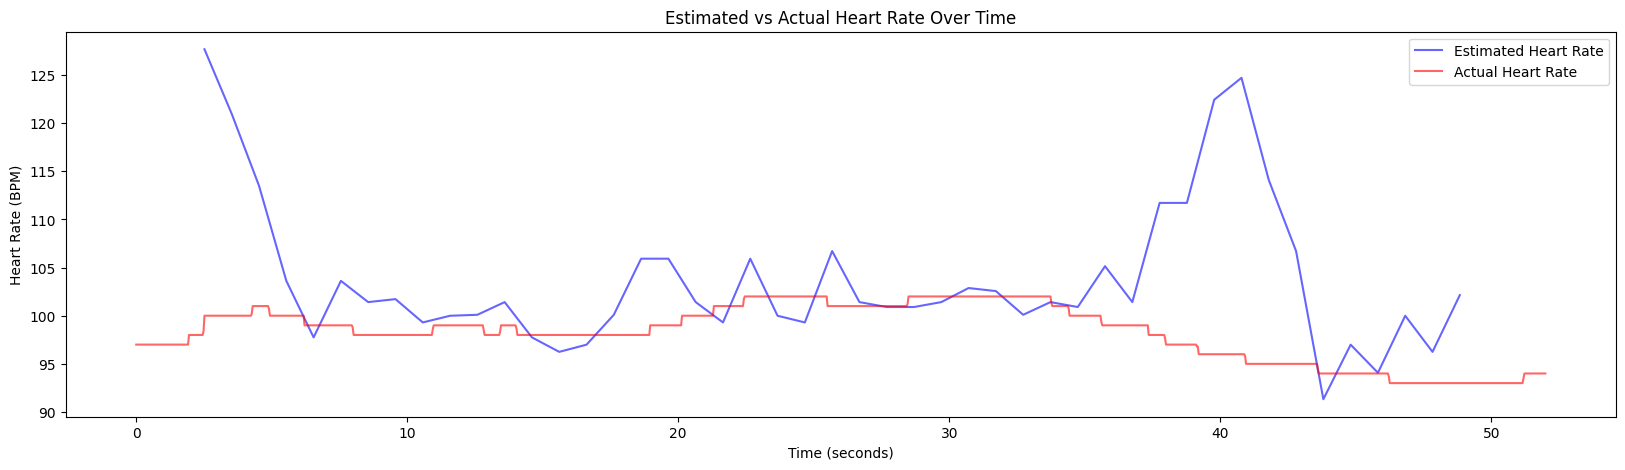

Average Estimated Heart Rate: 103.78
Average Actual Heart RateR: 98.28
MSE between average estimated and actual HR: 30.31
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject8.npz...


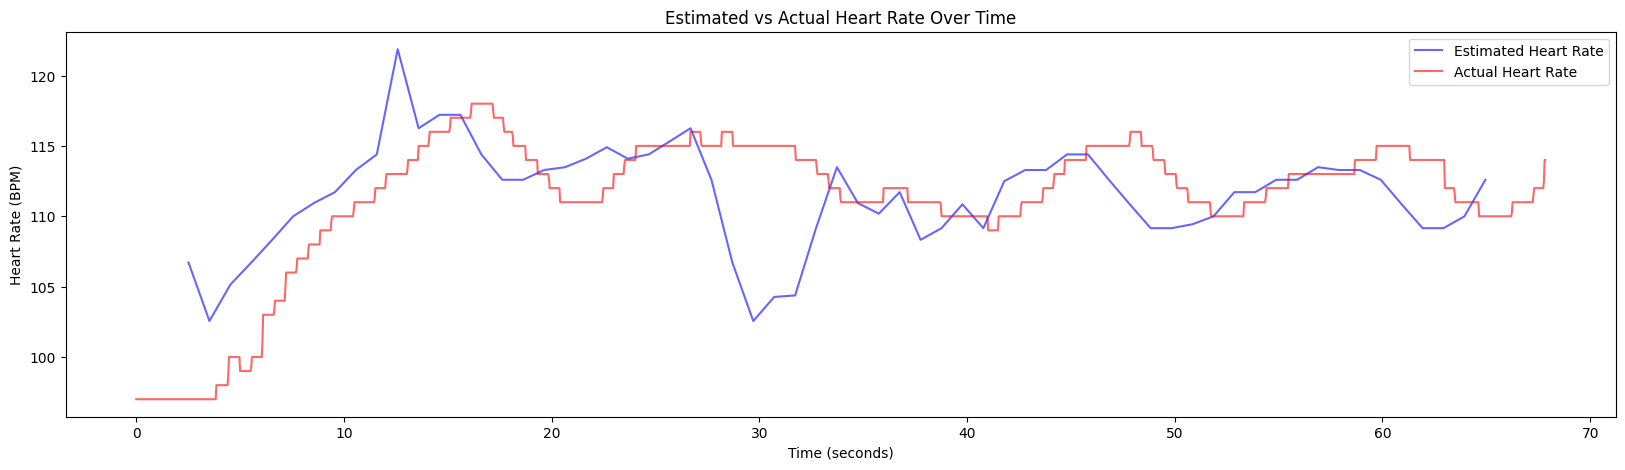

Average Estimated Heart Rate: 111.48
Average Actual Heart RateR: 111.24
MSE between average estimated and actual HR: 0.06
---------------------------------------------------------------------------
Processing /content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject9.npz...


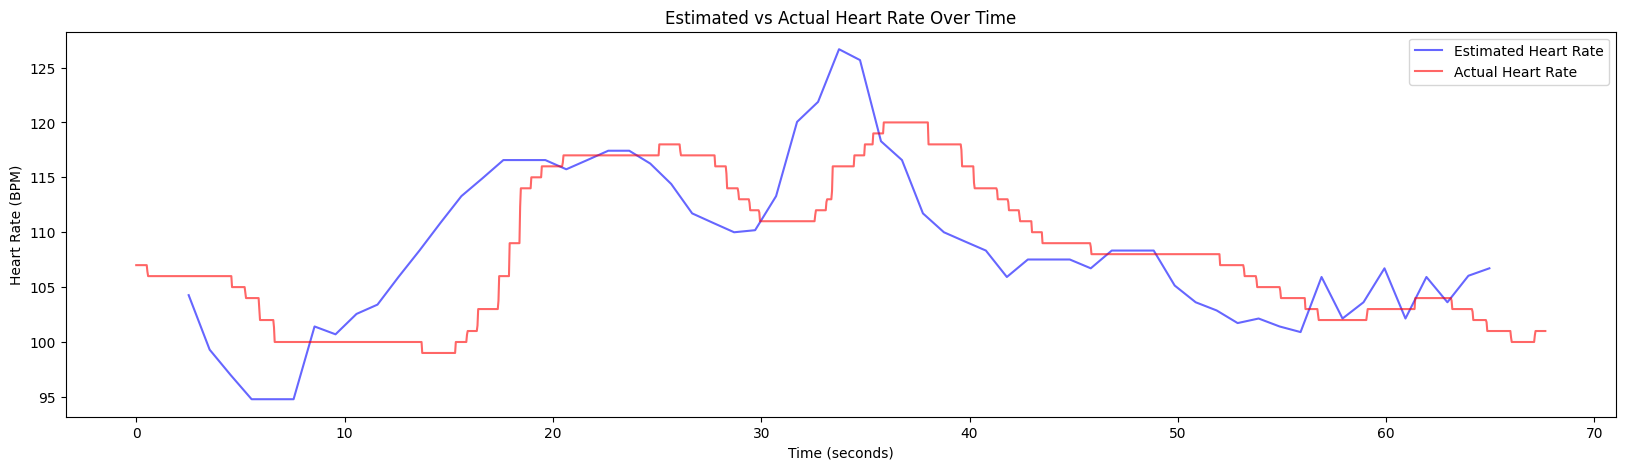

Average Estimated Heart Rate: 108.55
Average Actual Heart RateR: 108.19
MSE between average estimated and actual HR: 0.14
---------------------------------------------------------------------------


In [20]:
directory = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/'

mse_list, subject_list = process_npz_files(directory)

In [21]:
# 모든 파일의 MSE 출력
print("MSE List:", mse_list)
print("Average MSE across all files:", np.mean(mse_list))
print("---------------------------------------------------------------------------")

MSE List: [1.8947299596998157, 0.2688625805544523, 2.973029115302943, 7.686555488526028, 0.22778204726916368, 10.478907903586306, 0.0402021414778814, 1.0739708518537165, 2.6417904211669563, 1.7683280156640175, 64.88063189043802, 0.20965529964394414, 4.52763574169189, 46.43446814044484, 558.9304350364474, 618.4586366383128, 450.9471082333743, 7.082896169708622, 25.37911969174735, 1.6924931436689472, 3.4591840179465083, 0.0647525917199612, 0.5892735288552648, 2.2847106539061093, 0.01941617427970857, 132.92656769724977, 0.674397570158988, 88.21970188805855, 29.379952298615084, 0.8185087909940617, 4.185240524007639, 1.0671962251859, 3.0795660589277243, 0.22344381846060793, 1.049205139757808, 3.968205440810551e-05, 3.583022480373345, 10.589896283284434, 16.573048956677845, 30.310169466322762, 0.055898983981117326, 0.13526865981309544]
Average MSE across all files: 50.87823095240975
---------------------------------------------------------------------------


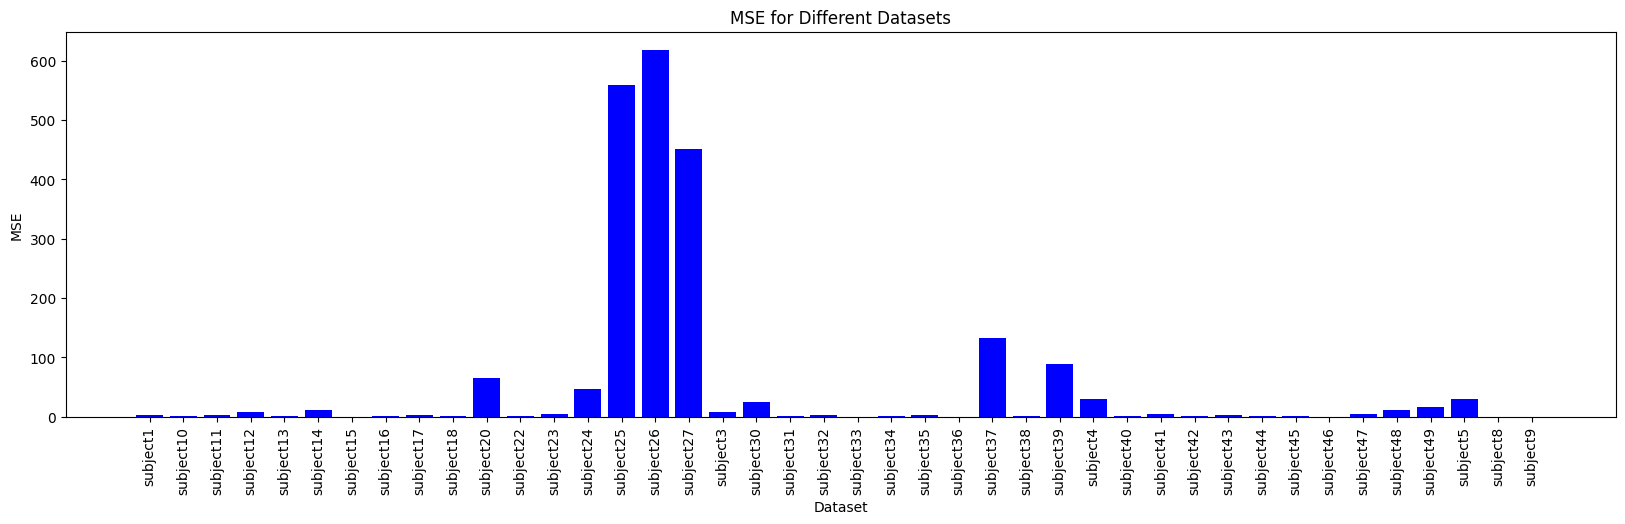

In [26]:
plt.figure(figsize=(20, 5))
plt.bar(subject_list, mse_list, color='blue')
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.title('MSE for Different Datasets')
plt.xticks(rotation='vertical')
plt.show()